# Passo a passo da construcao do codigo, limpeza, tratamento e data wrangling.

1. Instalando bibliotecas necessarias para analise

2. Importando as bibliotecas Yfinance, pandas, numpy,  matplotlib, seaborn dentre outras

3. Importando arquivo CSV dos valores historico do IBOVESPA e os respectivos tramanetos de coluna e mudanca de nome das colunas.

4. Extraindo informacoes sobre os tickers que existem no Ibovespa --> tickers = pd.read_html(
    'https://pt.wikipedia.org/wiki/Lista_de_companhias_citadas_no_Ibovespa')[0])

5. Extraindo apenas os codigos do ticker na primeira coluna passando a funcao .iloc[:,0]

6. tz = pytz.timezone("Brazil/East")
start = tz.localize(dt(2008,1,1))
end = tz.localize(dt.today()). Para alguns tickers nao conseguimos puxar sem o " fuso horario Brasileiro, entao foi necessario a implementacao de um fuso horario.

7. Determinando as empresas crimes dentro da variavel ticker

8. Puxando as informacoes de valores de fechamento da bolsa

9. Analisando valores faltantes usando a biblioteca sidetable e missingno e substituindo por valor 0

10. Importando arquivo CSV dos valores historico do IBOVESPA e os respectivos tramanetos de coluna e mudanca de nome das colunas.

11. O mesmo procedimento que foi realizado para buscar os ticker na Ibovespa, foi realizado para buscar tickers que sao negociados em outros pregoes, tais como Tokio, Estocolmo, Nova Yorke.

12. Para  compararmos como  cada ticker se comportou durante as suas janelas temporais, precisou de algumas etapas
- criacao de uma coluna de media movel para as suas respectivas anos, sempre como o padrao "xxx_return"
- passando a funcao pct_change().fillna(0) para nao perdermos informacoes por alguma linha contendo NAN
- usando um calculo ((1+dataframe.pct_change).cumprod-1)*100)+100 isso nos traz todos os tickers para valor inicial de 100, possibilitando uma analise mais adequada

13. Plotagem do grafico com a linha vertical simbolizando a data crime para facilitar a visualizacao dos fatos.



####1. Instalação de bibliotecas



In [ ]:
!pip install sidetable
!pip install missingno
!pip install seaborn
!pip install beautifulsoup4


####2. Importação ds bibliotecas necessárias para análise

In [ ]:
#bibliotecas essenciais para análise de dados
import pandas as pd
import yfinance as yf
import numpy as np

#bibliotecas para dados de datas
from datetime import datetime as dt
import pytz

#biblioteca para análise de dados/criação de gráficos
import sidetable as stb
import missingno as msno
import seaborn as sb
import matplotlib.pyplot as plt
import requests

sb.set_style('ticks')


3. Extração de dados da IBOVESPA em CSV

In [ ]:

df_bovespa=pd.read_csv("/content/^BVSP.csv")
df_bovespa

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-01-02,33462.0,33519.0,32860.0,33507.0,33507.0,0.0
1,2006-01-03,33507.0,34563.0,33507.0,34541.0,34541.0,0.0
2,2006-01-04,34540.0,35223.0,34540.0,35002.0,35002.0,0.0
3,2006-01-05,35006.0,35088.0,34681.0,34936.0,34936.0,0.0
4,2006-01-06,35170.0,35529.0,34940.0,35475.0,35475.0,0.0
...,...,...,...,...,...,...,...
4364,2023-07-24,120220.0,121772.0,120099.0,121342.0,121342.0,10494800.0
4365,2023-07-25,121344.0,123010.0,121344.0,122008.0,122008.0,11427100.0
4366,2023-07-26,122003.0,122747.0,121370.0,122560.0,122560.0,9988800.0
4367,2023-07-27,122560.0,122599.0,119825.0,119990.0,119990.0,10678700.0


In [ ]:
#extraindo todos os ticker da companha citadas no ibovespa
tickers = pd.read_html(
    'https://pt.wikipedia.org/wiki/Lista_de_companhias_citadas_no_Ibovespa')[0]
print(tickers.head())

  Código             Ação                                              Setor  \
0  ABEV3        AMBEV S/A  Consumo não Cíclico / Bebidas / Cervejas e Ref...   
1  AZUL4             AZUL   Bens Industriais / Transporte / Transporte Aéreo   
2  B3SA3               B3  Financeiro e Outros / Serviços Financeiros Div...   
3  BBAS3  BANCO DO BRASIL  Financeiro e Outros / Intermediários Financeir...   
4  BBDC3         BRADESCO  Financeiro e Outros / Intermediários Financeir...   

        Tipo                         Site  
0         ON       http://ri.ambev.com.br  
1      PN N2  https://www.voeazul.com.br/  
2      ON NM        http://www.b3.com.br/  
3  ON ERJ NM        http://www.bb.com.br/  
4      ON N1  http://www.bradesco.com.br/  


In [ ]:
#selecionando a primeira coluna para trazer apenas as sigras dos meus tickers
tickers_codigo=tickers.iloc[:,0].to_list()
print(tickers_codigo)

['ABEV3', 'AZUL4', 'B3SA3', 'BBAS3', 'BBDC3', 'BBDC4', 'BBSE3', 'BEEF3', 'BPAC11', 'BRAP4', 'BRDT3', 'BRFS3', 'BRKM5', 'BRML3', 'BRSR6', 'BTOW3', 'CCRO3', 'CIEL3', 'CMIG4', 'COGN3', 'CPFE3', 'CRFB3', 'CSAN3', 'CSNA3', 'CVCB3', 'CYRE3', 'ECOR3', 'EGIE3', 'ELET3', 'ELET6', 'EMBR3', 'ENBR3', 'ENGI11', 'EQTL3', 'FLRY3', 'GGBR4', 'GNDI3', 'GOAU4', 'GOLL4', 'HAPV3', 'HGTX3', 'HYPE3', 'IGTA3', 'IRBR3', 'ITSA4', 'ITUB4', 'JBSS3', 'KLBN11', 'LAME4', 'LREN3', 'MGLU3', 'MRFG3', 'MRVE3', 'MULT3', 'NTCO3', 'PCAR3', 'PETR3', 'PETR4', 'QUAL3', 'RADL3', 'RAIL3', 'RENT3', 'SANB11', 'SBSP3', 'SULA11', 'SUZB3', 'TAEE11', 'TIMP3', 'TOTS3', 'UGPA3', 'USIM5', 'VALE3', 'VIVT4', 'VVAR3', 'WEGE3', 'YDUQ3']


In [ ]:
tz = pytz.timezone("Brazil/East")
start = tz.localize(dt(2008,1,1))
end = tz.localize(dt.today())

In [ ]:
#atribuindo a variavel tickers passando todos a nossa lista
tickers = ('AMER3.SA','PETR4.SA', 'VALE3.SA', 'BRKM5.SA',
            'IRBR3.SA',  'JBSS3.SA')

In [ ]:
#fazendo download dos tickers
df_crime=yf.download(tickers,start, end, auto_adjust=True)['Close']
df_crime.head()

[*********************100%***********************]  6 of 6 completed


,AMER3.SA,BRKM5.SA,IRBR3.SA,JBSS3.SA,PETR4.SA,VALE3.SA
Date,,,,,,
2008-01-02,62.107311,7.062277,NaN,4.003692,12.912078,27.546082
2008-01-03,65.214821,7.007181,NaN,3.936401,12.704295,27.688810
2008-01-04,64.455017,6.721684,NaN,3.902759,12.080955,26.689737
2008-01-07,60.613327,6.811842,NaN,3.889301,11.726247,26.213984
2008-01-08,59.734009,6.826866,NaN,3.795096,12.370364,26.737301


4. Verificando valores faltantes, tratando nomes de colunas e retirando colunas sobressalentes

In [ ]:
#visualizando os tickers que nao foram puxados pelo Yfinance
df_crime.stb.missing()

,missing,total,percent
IRBR3.SA,2373,3876,61.22291
AMER3.SA,0,3876,0.00000
BRKM5.SA,0,3876,0.00000
JBSS3.SA,0,3876,0.00000
PETR4.SA,0,3876,0.00000
VALE3.SA,0,3876,0.00000


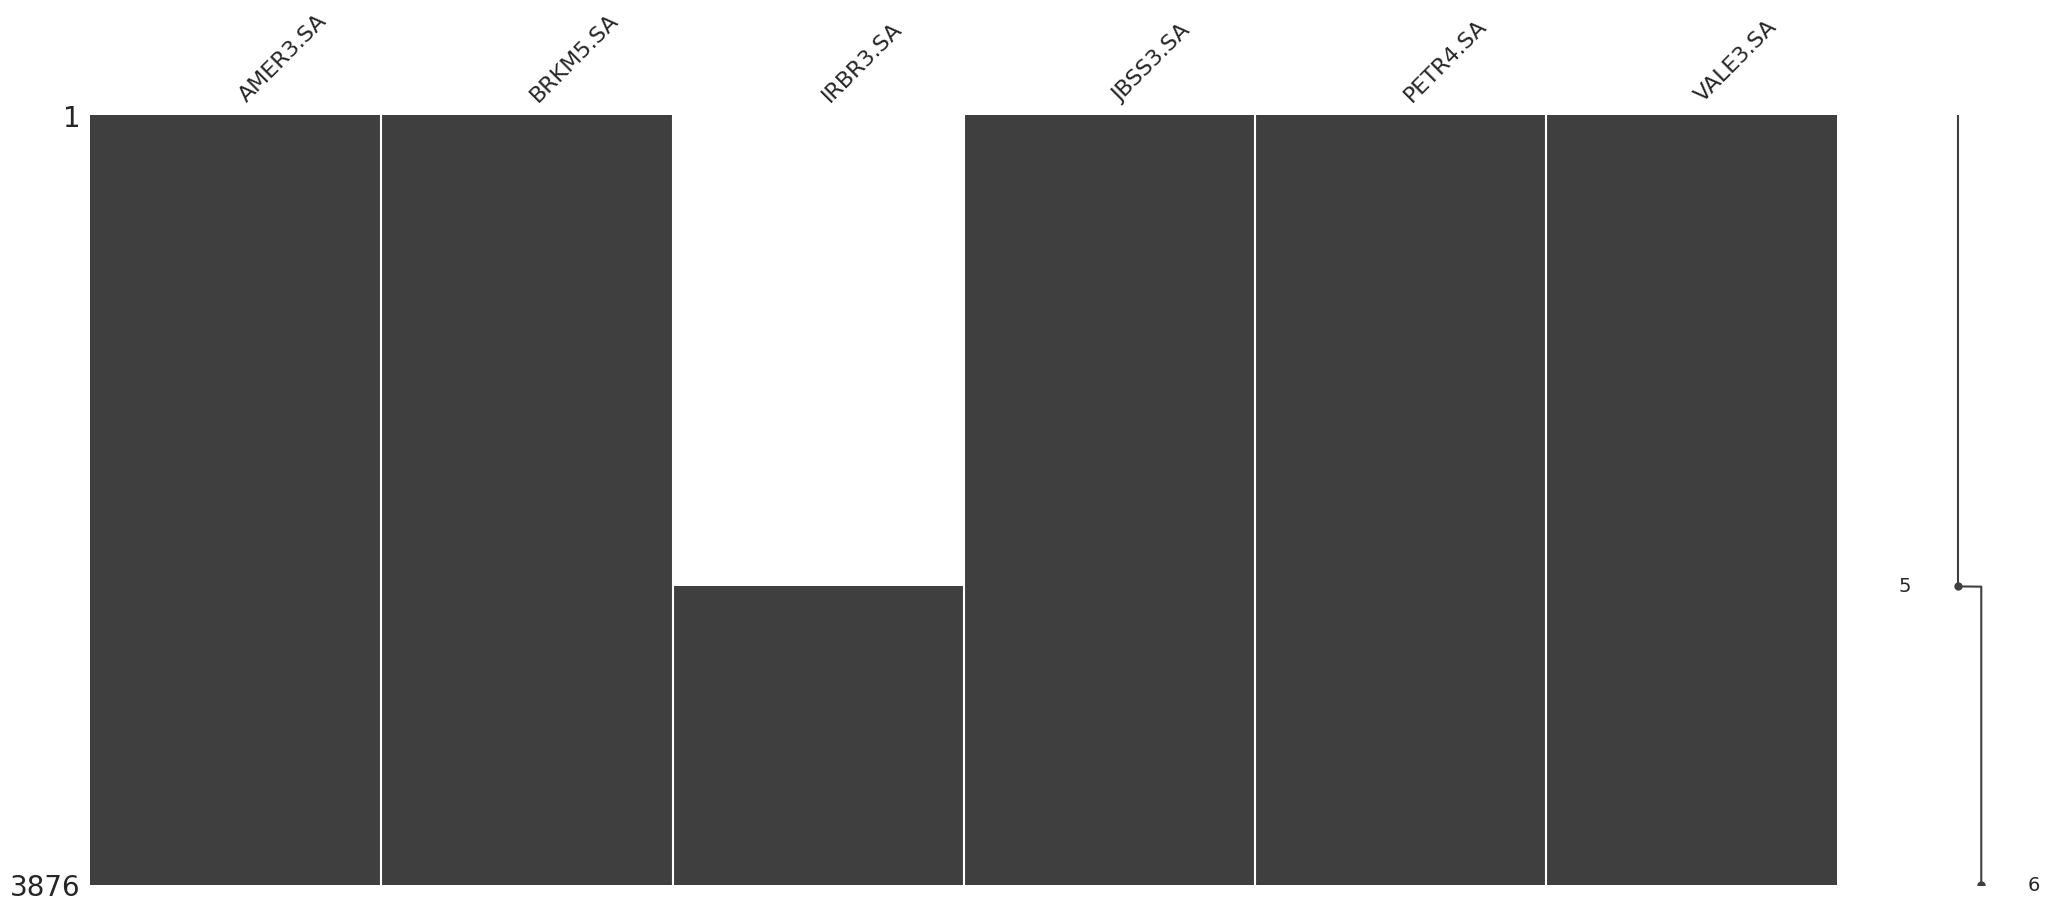

In [ ]:
#plotando um grafico de matrix para os valores faltantes
msno.matrix(df_crime);

In [ ]:
#entendendo as informacoes do nosso dataset
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3876 entries, 2008-01-02 to 2023-08-11
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AMER3.SA  3876 non-null   float64
 1   BRKM5.SA  3876 non-null   float64
 2   IRBR3.SA  1503 non-null   float64
 3   JBSS3.SA  3876 non-null   float64
 4   PETR4.SA  3876 non-null   float64
 5   VALE3.SA  3876 non-null   float64
dtypes: float64(6)
memory usage: 212.0 KB


In [ ]:
df_crime=df_crime.fillna(0)

In [ ]:
df_crime.tail()

,AMER3.SA,BRKM5.SA,IRBR3.SA,JBSS3.SA,PETR4.SA,VALE3.SA
Date,,,,,,
2023-08-07,1.11,23.320000,39.500000,19.450001,30.190001,67.900002
2023-08-08,1.10,23.850000,38.860001,19.469999,30.219999,67.459999
2023-08-09,1.09,23.389999,38.570000,19.260000,30.459999,66.849998
2023-08-10,1.06,24.990000,39.080002,19.379999,30.629999,66.059998
2023-08-11,1.06,24.129999,39.150002,19.350000,30.559999,65.510002


6. Plotando em gráficos os valores das empresas com histórico de crimes

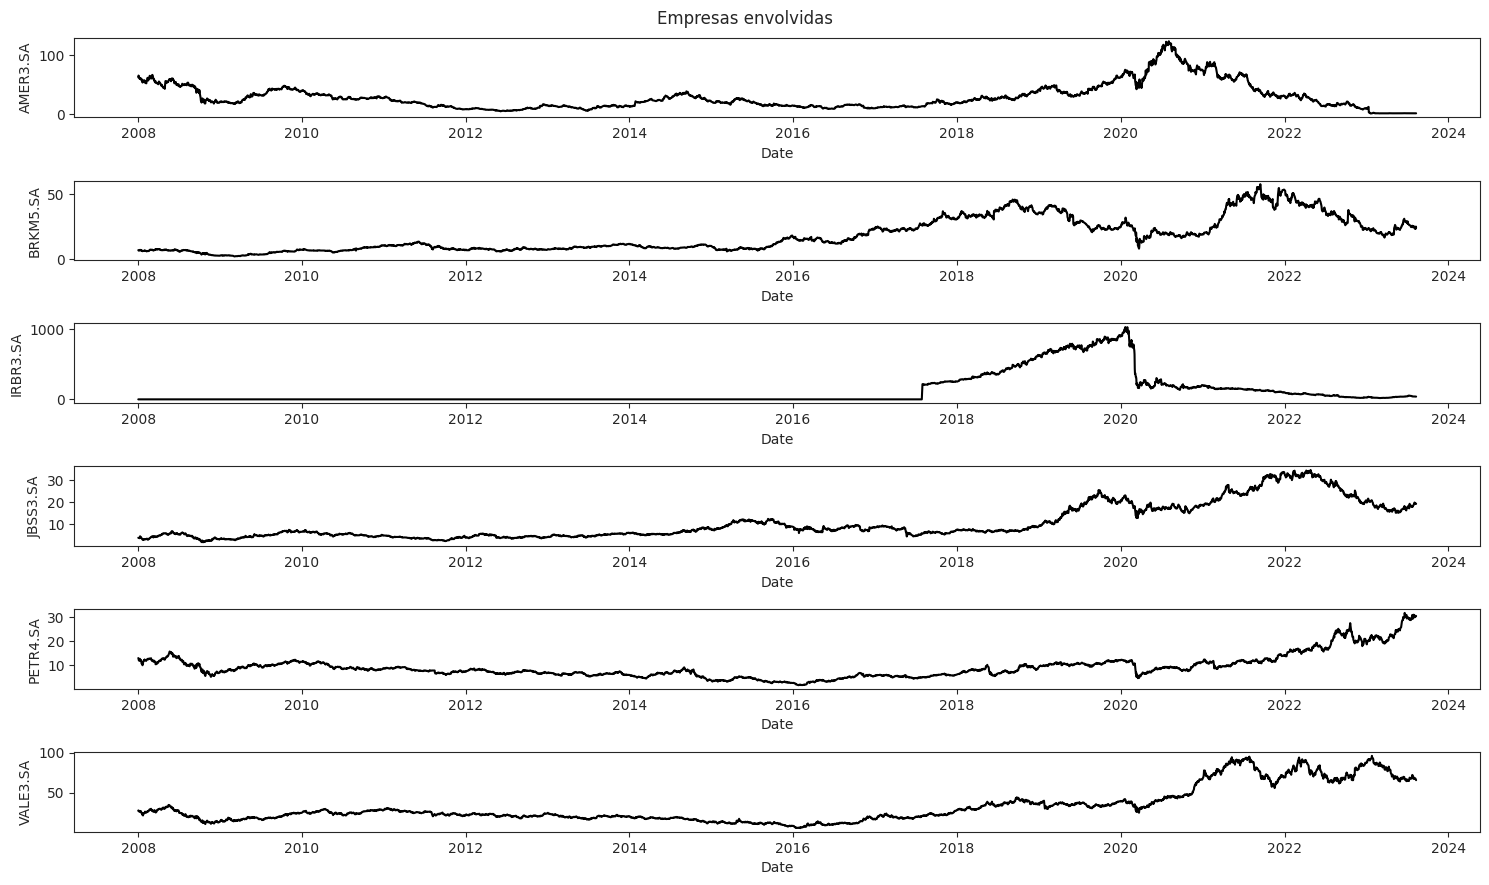

In [ ]:
plt.figure(figsize=(15,10))
for i , col in enumerate(df_crime):
    ax=plt.subplot(7, 1, i+1)
    sb.lineplot(data=df_crime, x= df_crime.index, y = col, color='k')
    plt.suptitle("Empresas envolvidas", size="12")
    plt.tight_layout()
    plt.savefig('crimes.png', dpi=300, bbox_inches='tight')

In [ ]:
#dropando as colunas que nao vao ser utilizados
df_bovespa.drop(columns=["Open","High","Low","Adj Close","Volume"], inplace=True)

In [ ]:
#transformando o Date para index
df_bovespa=df_bovespa.set_index("Date")

In [ ]:
#transformando a coluna de close para nome Bovespa
df_bovespa.columns=["Bovespa"]
df_bovespa.head(2)

,Bovespa
Date,
2006-01-02,33507.0
2006-01-03,34541.0


In [ ]:
#transformando o index em datetime
df_bovespa.index=pd.to_datetime(df_bovespa.index)

In [ ]:
#juntando as duas tabelas de df_crime e df_bovespa
df_all=pd.merge(df_crime, df_bovespa, how="left", left_index=True, right_index=True)

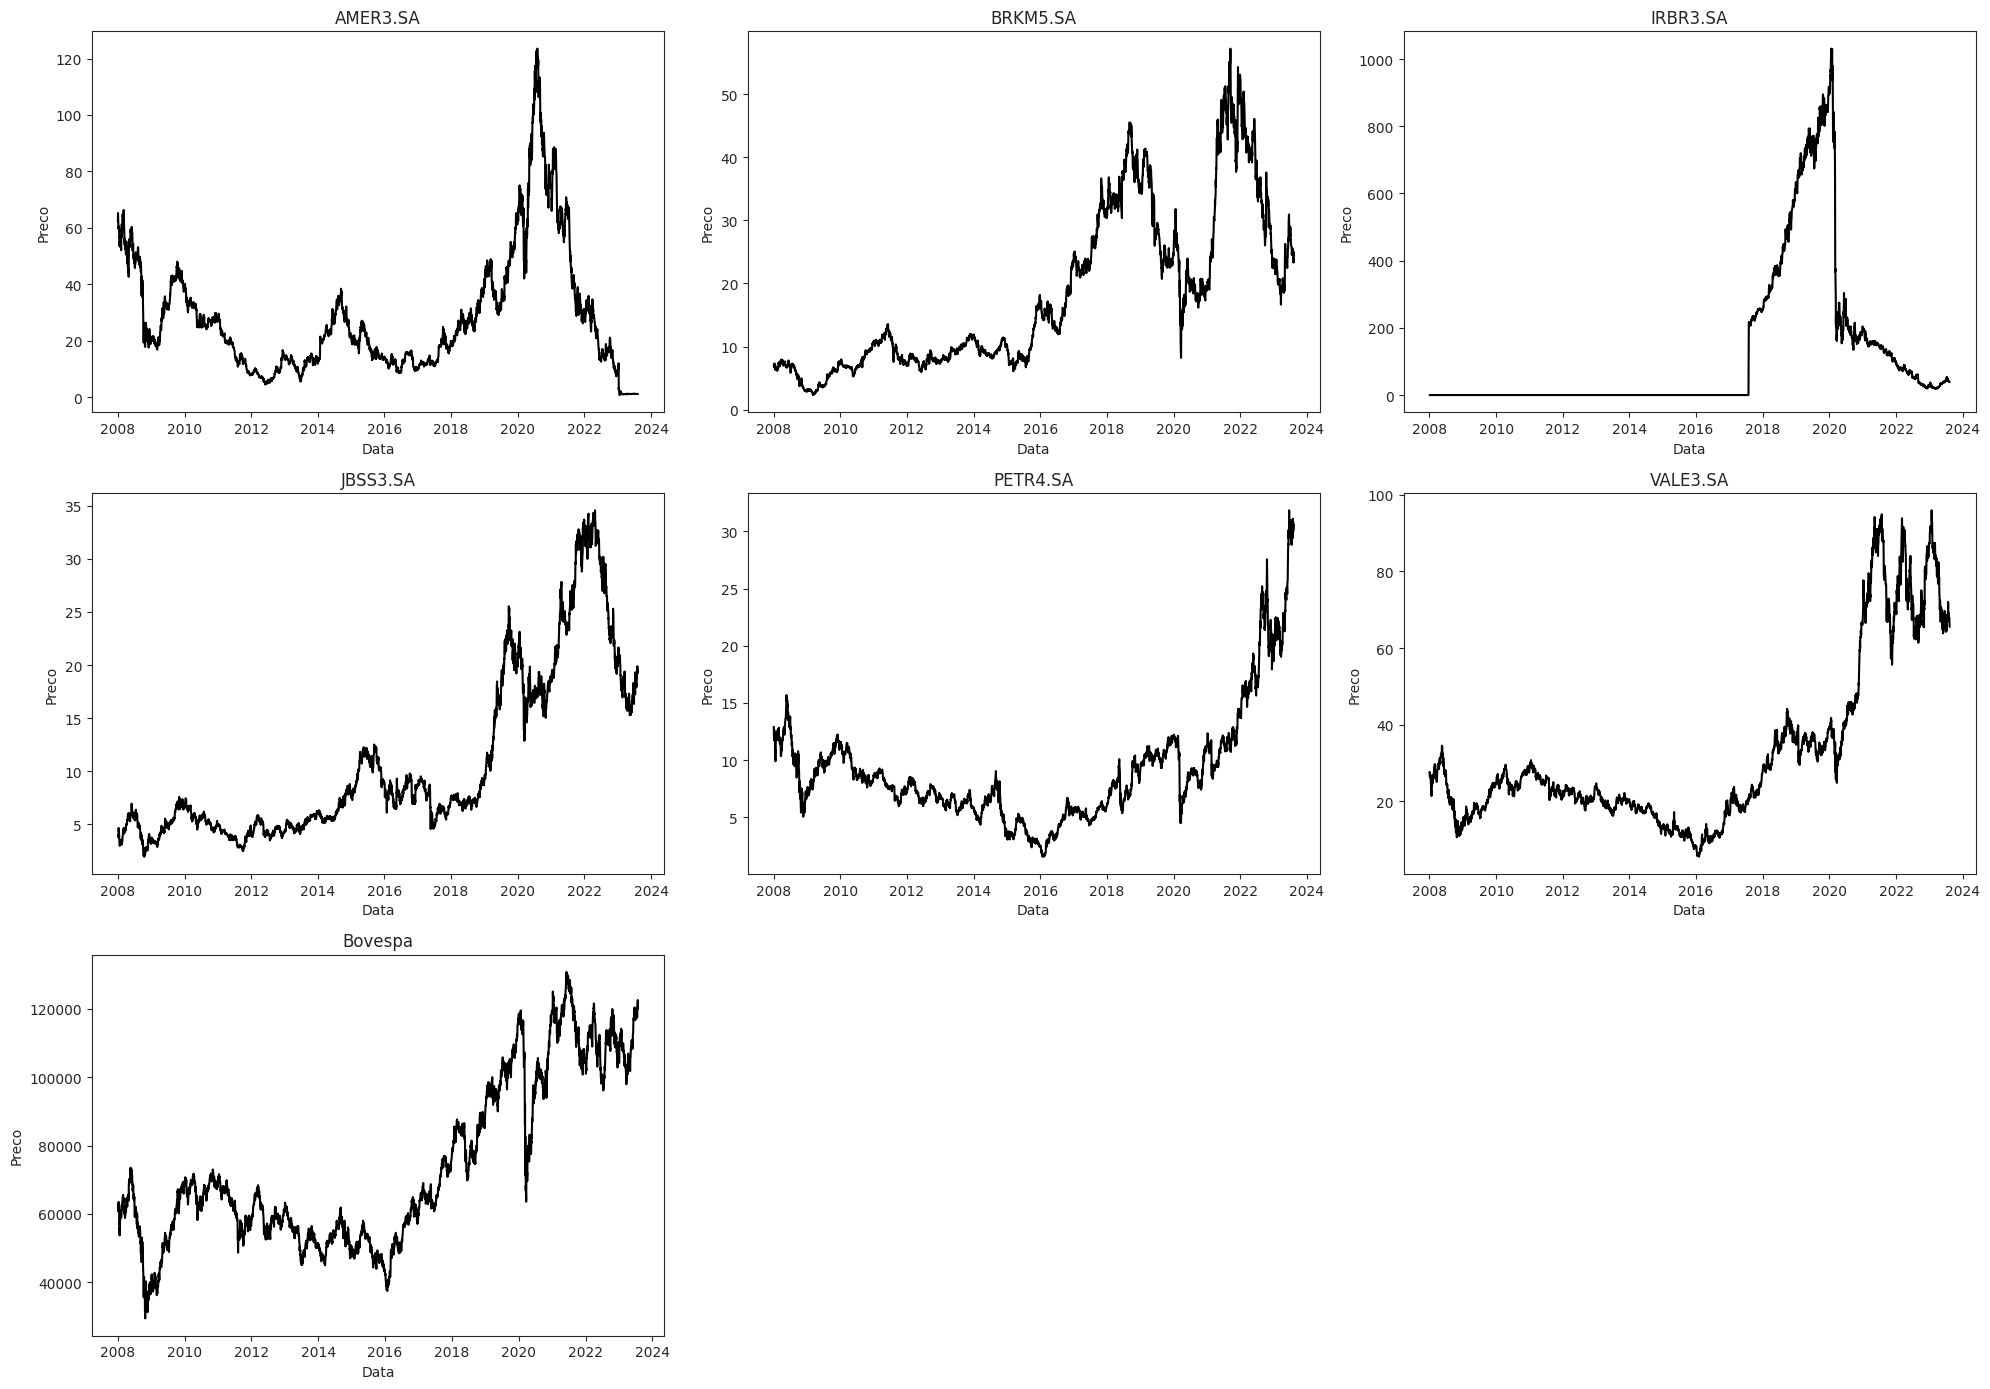

In [ ]:
plt.figure(figsize=(20,14))
for i ,  ticker in enumerate (df_all):
    plt.subplot(3, 3, i+1)
    sb.lineplot(data=df_all, x=df_all.index, y=ticker,color="k")
    plt.title(ticker)
    plt.ylabel("Preco")
    plt.xlabel("Data")
    plt.tight_layout()
    plt.savefig('Grafico dos crimes X Ibovespa', dpi=300, bbox_inches='tight')

<Axes: >

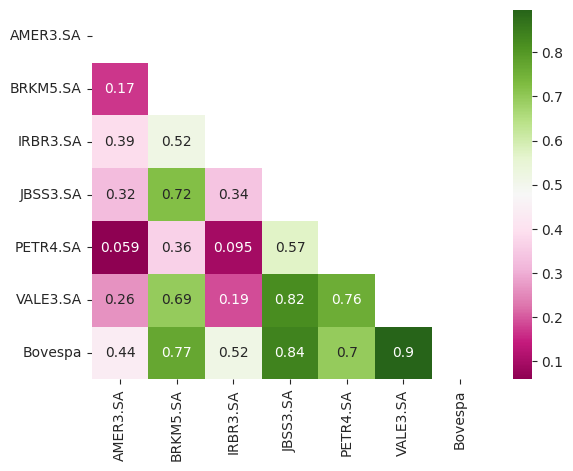

In [ ]:
#fazendo correlacao dos empresas
mask=np.triu(np.ones_like(df_all.corr()))
sb.heatmap(df_all.corr(), mask=mask, annot=True, cmap="PiYG")

7. Separação das empresas por dataset individual

In [ ]:
df_IRBR3=df_crime["IRBR3.SA"]
df_IRBR3.fillna(0)

Date
2008-01-02     0.000000
2008-01-03     0.000000
2008-01-04     0.000000
2008-01-07     0.000000
2008-01-08     0.000000
                ...    
2023-08-07    39.500000
2023-08-08    38.860001
2023-08-09    38.570000
2023-08-10    39.080002
2023-08-11    39.150002
Name: IRBR3.SA, Length: 3876, dtype: float64

In [ ]:
df_AMER3=df_crime["AMER3.SA"]
df_AMER3

Date
2008-01-02    62.107311
2008-01-03    65.214821
2008-01-04    64.455017
2008-01-07    60.613327
2008-01-08    59.734009
                ...    
2023-08-07     1.110000
2023-08-08     1.100000
2023-08-09     1.090000
2023-08-10     1.060000
2023-08-11     1.060000
Name: AMER3.SA, Length: 3876, dtype: float64

In [ ]:
df_BRKM5=df_crime["BRKM5.SA"]
df_BRKM5


Date
2008-01-02     7.062277
2008-01-03     7.007181
2008-01-04     6.721684
2008-01-07     6.811842
2008-01-08     6.826866
                ...    
2023-08-07    23.320000
2023-08-08    23.850000
2023-08-09    23.389999
2023-08-10    24.990000
2023-08-11    24.129999
Name: BRKM5.SA, Length: 3876, dtype: float64

In [ ]:
df_petrobras=df_crime["PETR4.SA"]
df_petrobras

Date
2008-01-02    12.912078
2008-01-03    12.704295
2008-01-04    12.080955
2008-01-07    11.726247
2008-01-08    12.370364
                ...    
2023-08-07    30.190001
2023-08-08    30.219999
2023-08-09    30.459999
2023-08-10    30.629999
2023-08-11    30.559999
Name: PETR4.SA, Length: 3876, dtype: float64

In [ ]:
df_vale=df_crime["VALE3.SA"]
df_vale

Date
2008-01-02    27.546082
2008-01-03    27.688810
2008-01-04    26.689737
2008-01-07    26.213984
2008-01-08    26.737301
                ...    
2023-08-07    67.900002
2023-08-08    67.459999
2023-08-09    66.849998
2023-08-10    66.059998
2023-08-11    65.510002
Name: VALE3.SA, Length: 3876, dtype: float64

In [ ]:
df_jbs=df_crime["JBSS3.SA"]
df_jbs

Date
2008-01-02     4.003692
2008-01-03     3.936401
2008-01-04     3.902759
2008-01-07     3.889301
2008-01-08     3.795096
                ...    
2023-08-07    19.450001
2023-08-08    19.469999
2023-08-09    19.260000
2023-08-10    19.379999
2023-08-11    19.350000
Name: JBSS3.SA, Length: 3876, dtype: float64

8. Extração dos tickers de todas empresas concorrentes


In [ ]:
tz = pytz.timezone("Brazil/East")
start = tz.localize(dt(2008,1,1))
end = tz.localize(dt.today())

In [ ]:
#Criação do dataset da concorrência

tickers = ['MGLU3.SA', 'VIIA3.SA', 'CRFB3.SA', 'CSN', 'AURA33.SA', 'RIO', 'BERK34.SA',
           'UGPA3.SA', 'UNIP6.SA', 'INN', 'SHEL', 'EQNR', 'XOM', 'CVX', 'REP', 'CYRE3.SA', 'MRVE3.SA',
           'EZTC3.SA', 'EVEN3.SA', 'TEND3.SA', 'BZ=F', 'ECOR3.SA', 'EQNR', 'MUV2.DE', 'SREN',
           'SCR.PA', 'PSSA3.SA', 'RDOR3.SA', 'ECOR3.SA',"AALR3.SA","BEEF3.SA","MRFG3.SA","BRFS3.SA",
           "SU","GE","MIELY"]

df_conc = []
df_conc = yf.download(tickers,start, end, auto_adjust=True)["Close"]
print(df_conc)

[*********************100%***********************]  34 of 34 completed
             AALR3.SA  AURA33.SA   BEEF3.SA  BERK34.SA   BRFS3.SA       BZ=F  \
Date                                                                           
2008-01-02        NaN        NaN   7.897236        NaN  18.938053  97.839996   
2008-01-03        NaN        NaN   8.179280        NaN  19.027386  97.599998   
2008-01-04        NaN        NaN   8.090214        NaN  18.357407  96.790001   
2008-01-07        NaN        NaN   8.090214        NaN  18.938053  94.389999   
2008-01-08        NaN        NaN   8.142170        NaN  18.982723  95.540001   
...               ...        ...        ...        ...        ...        ...   
2023-08-07  24.270000  35.900002  10.620000  88.550003  10.080000  85.339996   
2023-08-08  24.110001  34.500000  10.610000  88.980003   9.850000  86.169998   
2023-08-09  23.150000  33.599998  10.750000  87.790001   9.660000  87.550003   
2023-08-10  23.910000  32.000000  11.060000  86.8

9. Extração das empresas concorrentes fora do Brasil

In [ ]:
tz = pytz.timezone("Australia/Sydney")
start = tz.localize(dt(2008,1,1))
end = tz.localize(dt.today())


In [ ]:
tickers=["HON","SU","MIELY","GE", ]
df_conc1 = yf.download(tickers,start, end, auto_adjust=True)["Close"]
print(df_conc1)

[*********************100%***********************]  4 of 4 completed
                    GE         HON      MIELY         SU
Date                                                    
2007-12-31  147.511292   40.904167  20.900000  36.464470
2008-01-02  146.277756   39.794704  20.900000  36.980934
2008-01-03  146.436859   39.993996  20.900000  37.873001
2008-01-04  143.412643   38.718441  20.150000  36.689152
2008-01-07  143.969711   38.585564  19.900000  36.202881
...                ...         ...        ...        ...
2023-08-07  114.730003  188.568054  26.440001  30.879999
2023-08-08  113.550003  186.628647  26.299999  31.110001
2023-08-09  112.169998  188.210007  25.650000  31.719999
2023-08-10  113.570000  188.740005  25.830000  31.559999
2023-08-11  114.599998  190.669998  25.809999  31.719999

[3931 rows x 4 columns]


In [ ]:
tz = pytz.timezone("Europe/Stockholm")
start = tz.localize(dt(2008,1,1))
end = tz.localize(dt.today())

In [ ]:
df_conc2 = yf.download("ABBN.SW",start, end, auto_adjust=True)["Close"]
print(df_conc2)

[*********************100%***********************]  1 of 1 completed
Date
2008-01-03    17.135260
2008-01-04    16.364887
2008-01-07    15.594517
2008-01-08    16.265837
2008-01-09    15.858641
                ...    
2023-08-07    34.560001
2023-08-08    34.139999
2023-08-09    34.400002
2023-08-10    33.650002
2023-08-11    33.810001
Name: Close, Length: 3929, dtype: float64


In [ ]:
#visualizando os valores faltantes
print(df_conc)

             AALR3.SA  AURA33.SA   BEEF3.SA  BERK34.SA   BRFS3.SA       BZ=F  \
Date                                                                           
2008-01-02        NaN        NaN   7.897236        NaN  18.938053  97.839996   
2008-01-03        NaN        NaN   8.179280        NaN  19.027386  97.599998   
2008-01-04        NaN        NaN   8.090214        NaN  18.357407  96.790001   
2008-01-07        NaN        NaN   8.090214        NaN  18.938053  94.389999   
2008-01-08        NaN        NaN   8.142170        NaN  18.982723  95.540001   
...               ...        ...        ...        ...        ...        ...   
2023-08-07  24.270000  35.900002  10.620000  88.550003  10.080000  85.339996   
2023-08-08  24.110001  34.500000  10.610000  88.980003   9.850000  86.169998   
2023-08-09  23.150000  33.599998  10.750000  87.790001   9.660000  87.550003   
2023-08-10  23.910000  32.000000  11.060000  86.849998   9.830000  86.400002   
2023-08-11  22.750000  32.500000  10.810

10. Tratando os dados missing com fillna (transformando NAN em 0)

In [ ]:
#trocando os valores faltantes por 0
df_conc.fillna(0)


,AALR3.SA,AURA33.SA,BEEF3.SA,BERK34.SA,BRFS3.SA,BZ=F,CRFB3.SA,CSN,CVX,CYRE3.SA,...,RIO,SCR.PA,SHEL,SREN,SU,TEND3.SA,UGPA3.SA,UNIP6.SA,VIIA3.SA,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,0.000000,0.000000,7.897236,0.000000,18.938053,97.839996,0.00,9.95,51.267384,14.649400,...,37.468155,6.039192,36.471443,0.0,36.980915,9.497332,5.821820,3.759061,7.162282,53.551968
2008-01-03,0.000000,0.000000,8.179280,0.000000,19.027386,97.599998,0.00,9.58,51.898235,14.513473,...,38.235893,5.806381,37.252312,0.0,37.873005,9.871612,5.821820,3.759061,7.162282,53.735176
2008-01-04,0.000000,0.000000,8.090214,0.000000,18.357407,96.790001,0.00,9.27,51.207039,14.210722,...,36.316517,5.716036,36.497475,0.0,36.689167,9.684471,5.821820,3.737077,7.162282,52.733006
2008-01-07,0.000000,0.000000,8.090214,0.000000,18.938053,94.389999,0.00,8.82,50.537827,14.210722,...,35.916580,5.719511,37.395470,0.0,36.202881,9.254050,5.821820,3.693112,7.162282,52.240498
2008-01-08,0.000000,0.000000,8.142170,0.000000,18.982723,95.540001,0.00,9.28,49.890533,15.044829,...,35.182743,5.736886,36.050632,0.0,36.035202,9.356978,5.821820,3.737077,8.975435,51.570435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-07,24.270000,35.900002,10.620000,88.550003,10.080000,85.339996,12.10,0.00,159.889999,24.900000,...,62.270279,0.000000,60.789436,0.0,30.879999,13.190000,19.260000,80.489998,1.870000,107.199997
2023-08-08,24.110001,34.500000,10.610000,88.980003,9.850000,86.169998,12.05,0.00,159.649994,24.969999,...,61.803612,27.780001,61.026897,0.0,31.110001,13.980000,19.290001,80.000000,1.830000,107.730003
2023-08-09,23.150000,33.599998,10.750000,87.790001,9.660000,87.550003,11.78,0.00,159.860001,24.870001,...,61.930000,28.150000,61.858002,0.0,31.719999,13.960000,19.170000,79.930000,1.890000,109.559998


In [ ]:
#Verificando as colunas do dataframe da concorrência
df_conc.columns.tolist()

['AALR3.SA',
 'AURA33.SA',
 'BEEF3.SA',
 'BERK34.SA',
 'BRFS3.SA',
 'BZ=F',
 'CRFB3.SA',
 'CSN',
 'CVX',
 'CYRE3.SA',
 'ECOR3.SA',
 'EQNR',
 'EVEN3.SA',
 'EZTC3.SA',
 'GE',
 'INN',
 'MGLU3.SA',
 'MIELY',
 'MRFG3.SA',
 'MRVE3.SA',
 'MUV2.DE',
 'PSSA3.SA',
 'RDOR3.SA',
 'REP',
 'RIO',
 'SCR.PA',
 'SHEL',
 'SREN',
 'SU',
 'TEND3.SA',
 'UGPA3.SA',
 'UNIP6.SA',
 'VIIA3.SA',
 'XOM']


11. Separação dos datasets da concorrência das empresas com registro de crimes.

- Como os alguns concorrentes foram obtidos em pregões diferentes tivemos que unir as informacões em apenas um dataset usando o a funcão merge

 Criação do dataframe das empresas concorrentes da Siemens e plotando em gráfico os resultados

In [ ]:
# unindo os dataset de concorrentes da siemens
df_con_siemens=(pd.merge(df_conc1, df_conc2, how="left", left_index=True, right_index=True)
.rename({"Close":"ABB"}, axis=1))

In [ ]:
df_con_siemens.fillna(0)

,GE,HON,MIELY,SU,ABB
Date,,,,,
2007-12-31,147.511292,40.904167,20.900000,36.464470,0.000000
2008-01-02,146.277756,39.794704,20.900000,36.980934,0.000000
2008-01-03,146.436859,39.993996,20.900000,37.873001,17.135260
2008-01-04,143.412643,38.718441,20.150000,36.689152,16.364887
2008-01-07,143.969711,38.585564,19.900000,36.202881,15.594517
...,...,...,...,...,...
2023-08-07,114.730003,188.568054,26.440001,30.879999,34.560001
2023-08-08,113.550003,186.628647,26.299999,31.110001,34.139999
2023-08-09,112.169998,188.210007,25.650000,31.719999,34.400002


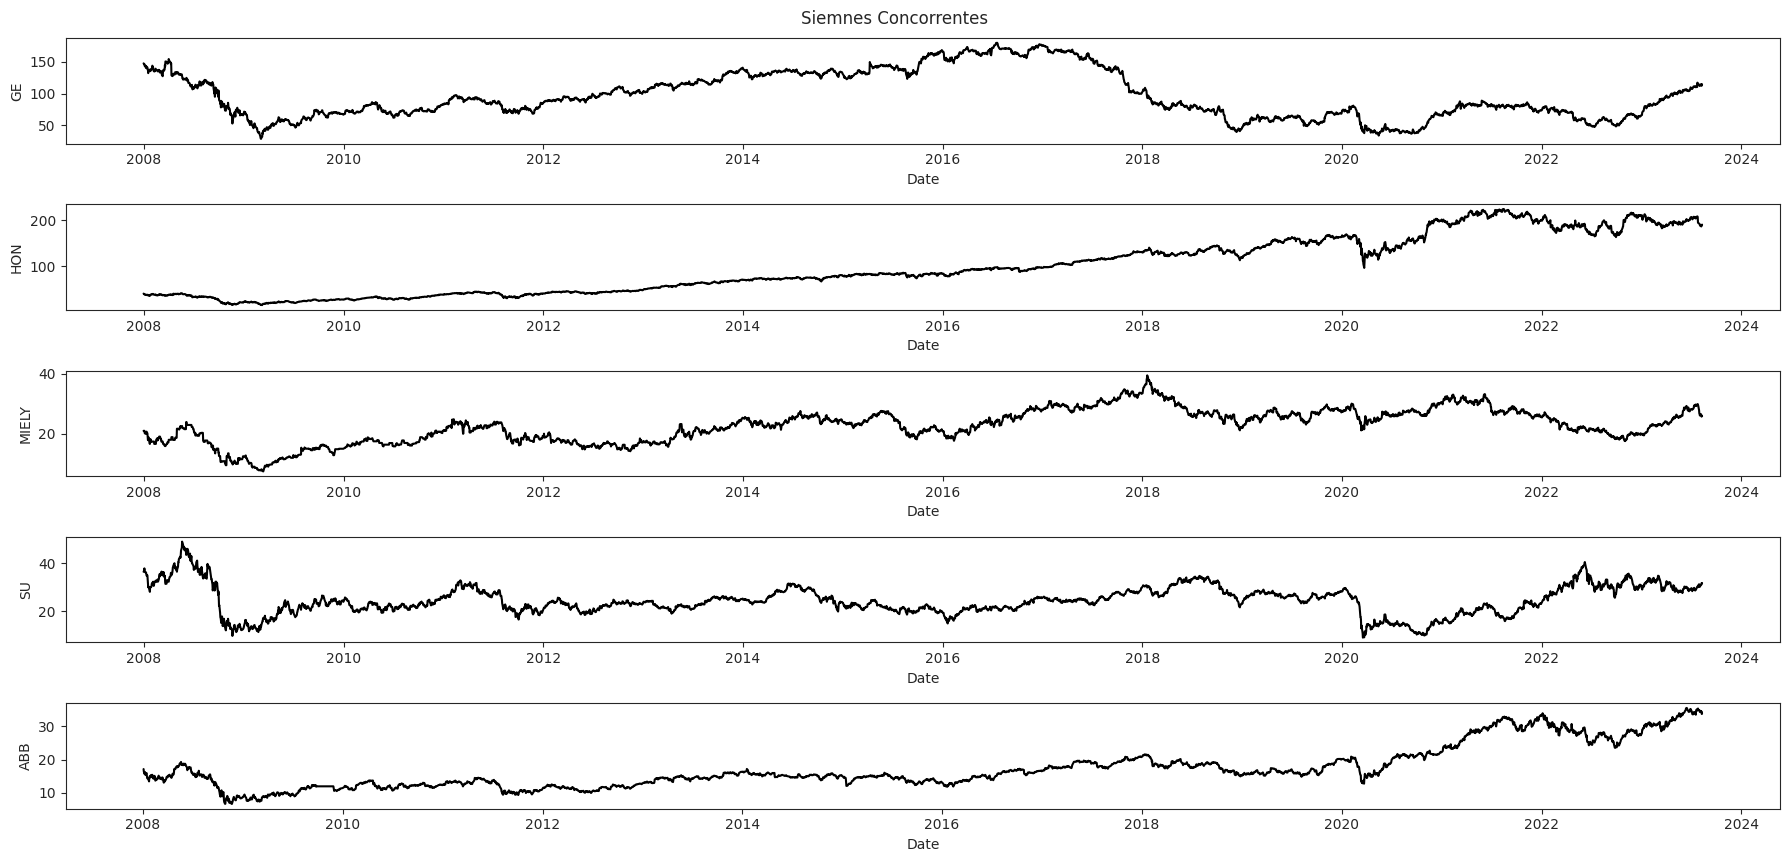

In [ ]:
#Plotando em gráfico as concorrentes da Siemens
plt.figure(figsize=(18,10))
for i , col in enumerate(df_con_siemens):
    ax=plt.subplot(6, 1, i+1)
    sb.lineplot(data=df_con_siemens, x=df_con_siemens.index, y=col, color='k')
    plt.suptitle("Siemnes Concorrentes", size="12")
    plt.tight_layout()
    plt.savefig('Conc_Siemens.png', dpi=300, bbox_inches='tight')

13. Criação do dataframe das empresas concorrentes da JBS e plotando em gráfico os resultados

In [ ]:
df_con_jbs=df_conc[["AALR3.SA","BEEF3.SA","MRFG3.SA","BRFS3.SA"]]

In [ ]:
df_con_jbs.fillna(0)

,AALR3.SA,BEEF3.SA,MRFG3.SA,BRFS3.SA
Date,,,,
2008-01-02,0.000000,7.897236,9.769298,18.938053
2008-01-03,0.000000,8.179280,9.775706,19.027386
2008-01-04,0.000000,8.090214,9.775706,18.357407
2008-01-07,0.000000,8.090214,9.711605,18.938053
2008-01-08,0.000000,8.142170,9.743655,18.982723
...,...,...,...,...
2023-08-07,24.270000,10.620000,8.090000,10.080000
2023-08-08,24.110001,10.610000,7.940000,9.850000
2023-08-09,23.150000,10.750000,7.800000,9.660000


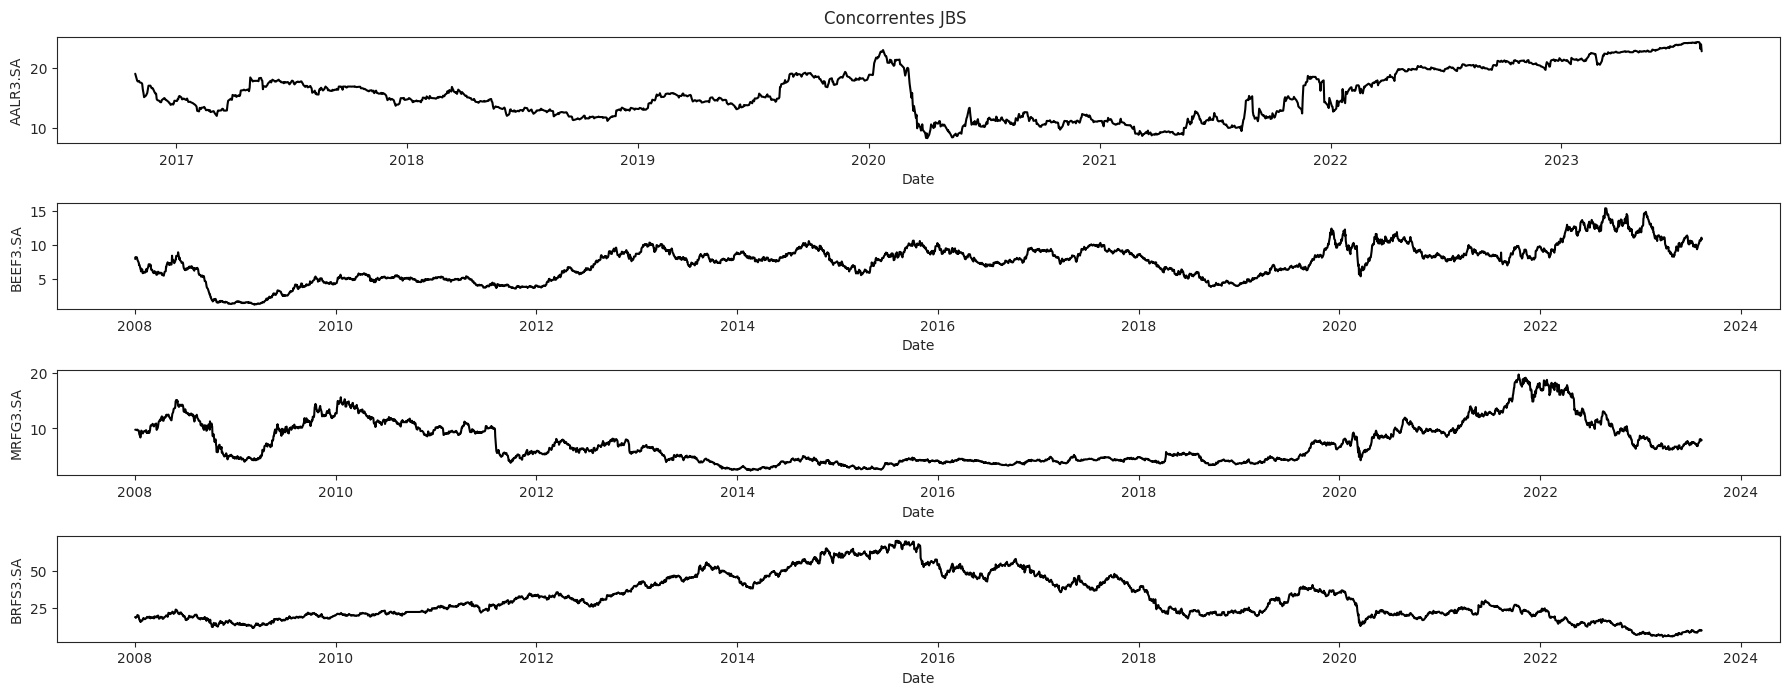

In [ ]:
#Plotando em gráfico as concorrentes da JBS
plt.figure(figsize=(18,10))
for i , col in enumerate(df_con_jbs):
    ax=plt.subplot(6, 1, i+1)
    sb.lineplot(data=df_con_jbs, x=df_con_jbs.index, y=col, color='k')
    plt.suptitle("Concorrentes JBS", size="12")
    plt.tight_layout()
    plt.savefig('JBS_CONC.png', dpi=300, bbox_inches='tight')

13. Criação do dataframe das empresas concorrentes da Petrobrás e plotando em gráfico os resultados

In [ ]:
#Criando um dafaframe isolando as concorrentes da Petrobrás
df_con_petro = df_conc[['SHEL','EQNR', 'XOM', 'CVX', 'BZ=F']]

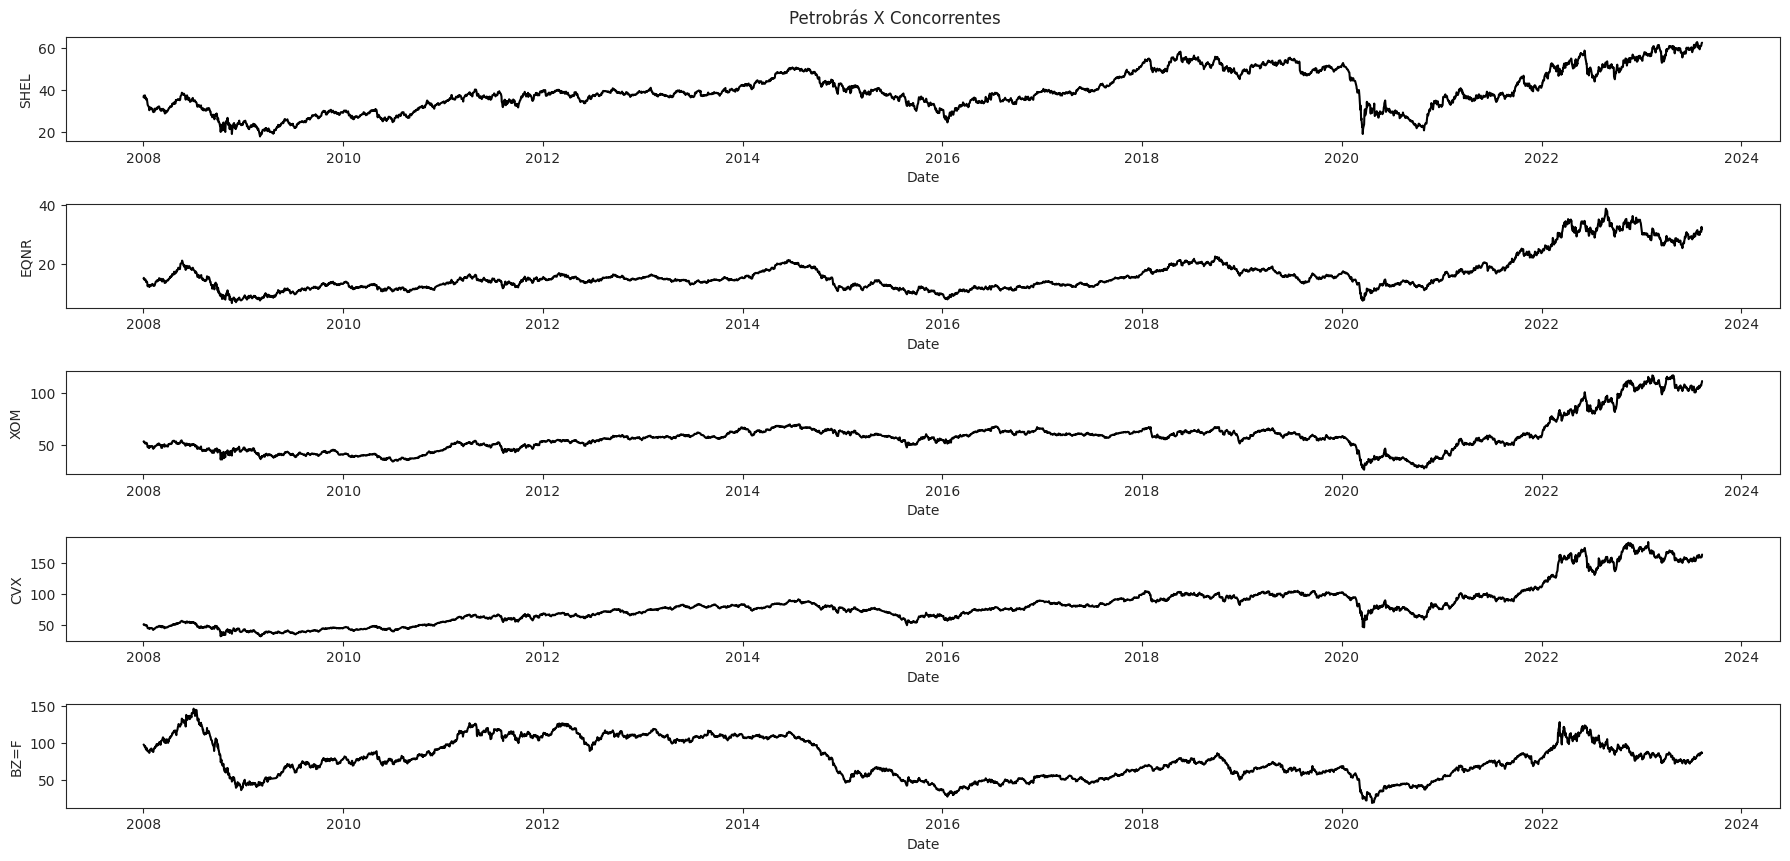

In [ ]:
#Plotando em gráfico as concorrentes da Petrobrás
plt.figure(figsize=(18,10))
for i , col in enumerate(df_con_petro):
    plt.subplot(6, 1, i+1)
    sb.lineplot(data=df_con_petro, x=df_con_petro.index, y=col, color='k')
    plt.suptitle("Petrobrás X Concorrentes")
    plt.tight_layout()
    plt.savefig('Petrobras.png', dpi=300, bbox_inches='tight')

14. Criação do dataframe das empresas concorrentes da Odebrecht e plotando em gráfico os resultados

In [ ]:
#Criando dataframe Odebrech
df_con_ode = df_conc[['CYRE3.SA', 'MRVE3.SA' ,'EZTC3.SA', 'EVEN3.SA', 'TEND3.SA']]

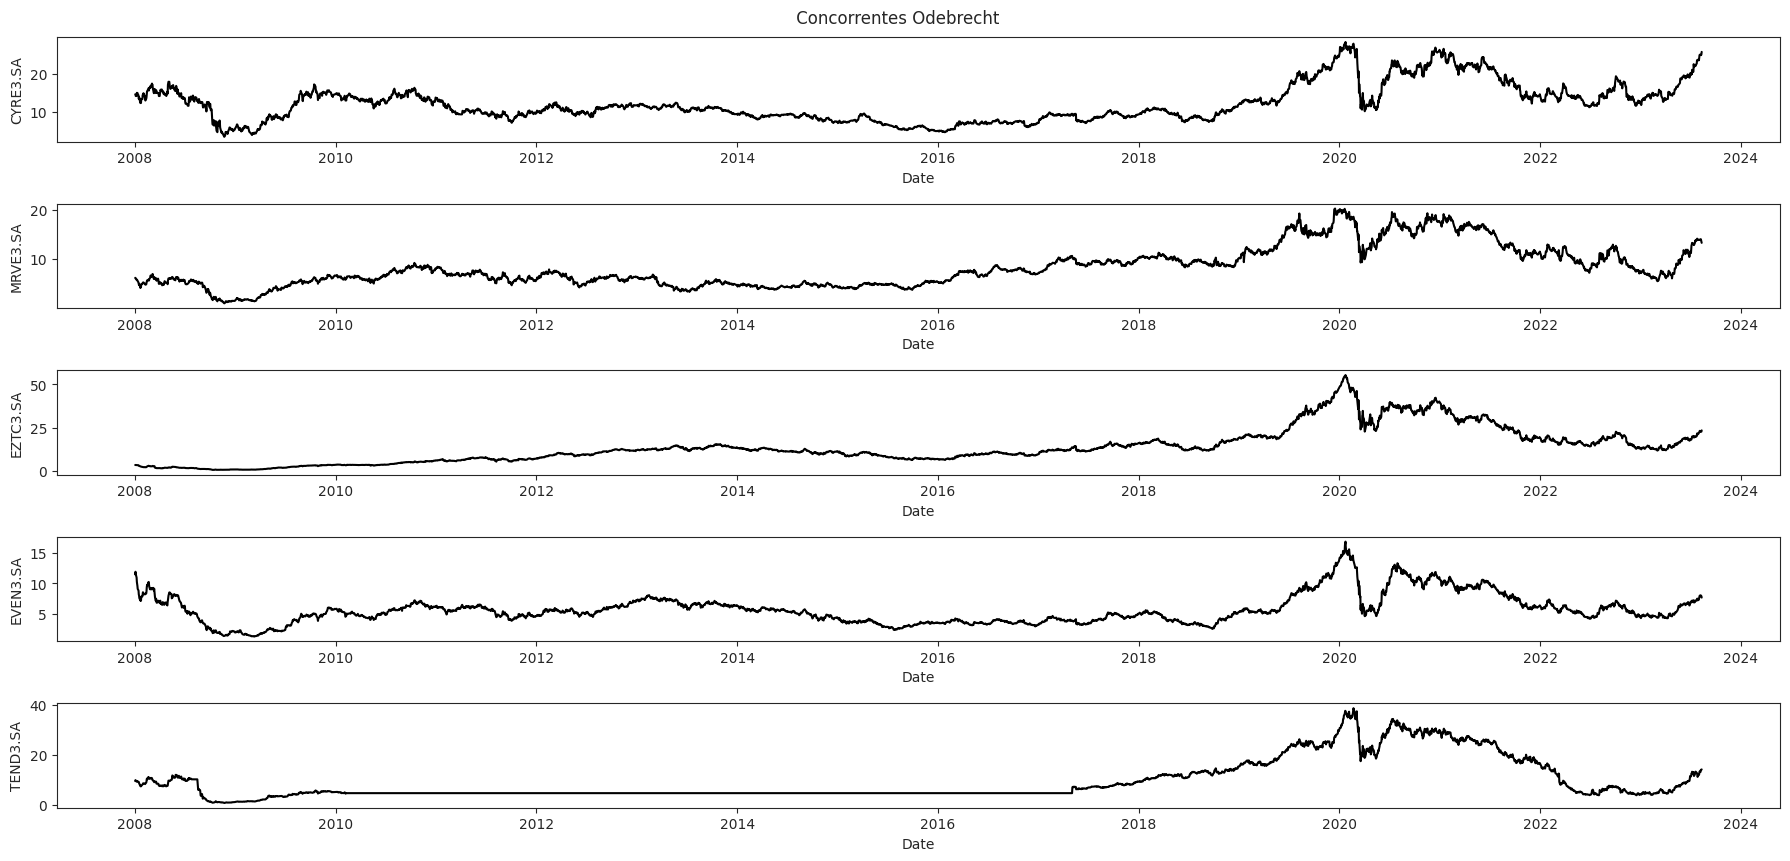

In [ ]:
#Plotando os gráficos do Dataframe Odebrech
plt.figure(figsize=(18,10))
for i , col in enumerate(df_con_ode):
    ax=plt.subplot(6, 1, i+1)
    sb.lineplot(data=df_con_ode, x=df_con_ode.index, y=col, color='k')
    plt.suptitle(" Concorrentes Odebrecht", size="12")
    plt.tight_layout()
    plt.savefig('Odebrech.png', dpi=300, bbox_inches='tight')

15. Criação do dataframe das empresas concorrentes da Braskem e plotando em gráfico os resultados

In [ ]:
#Criando o Dataframe da Braskem
df_con_bras = df_conc[['UGPA3.SA', 'UNIP6.SA', 'INN']]

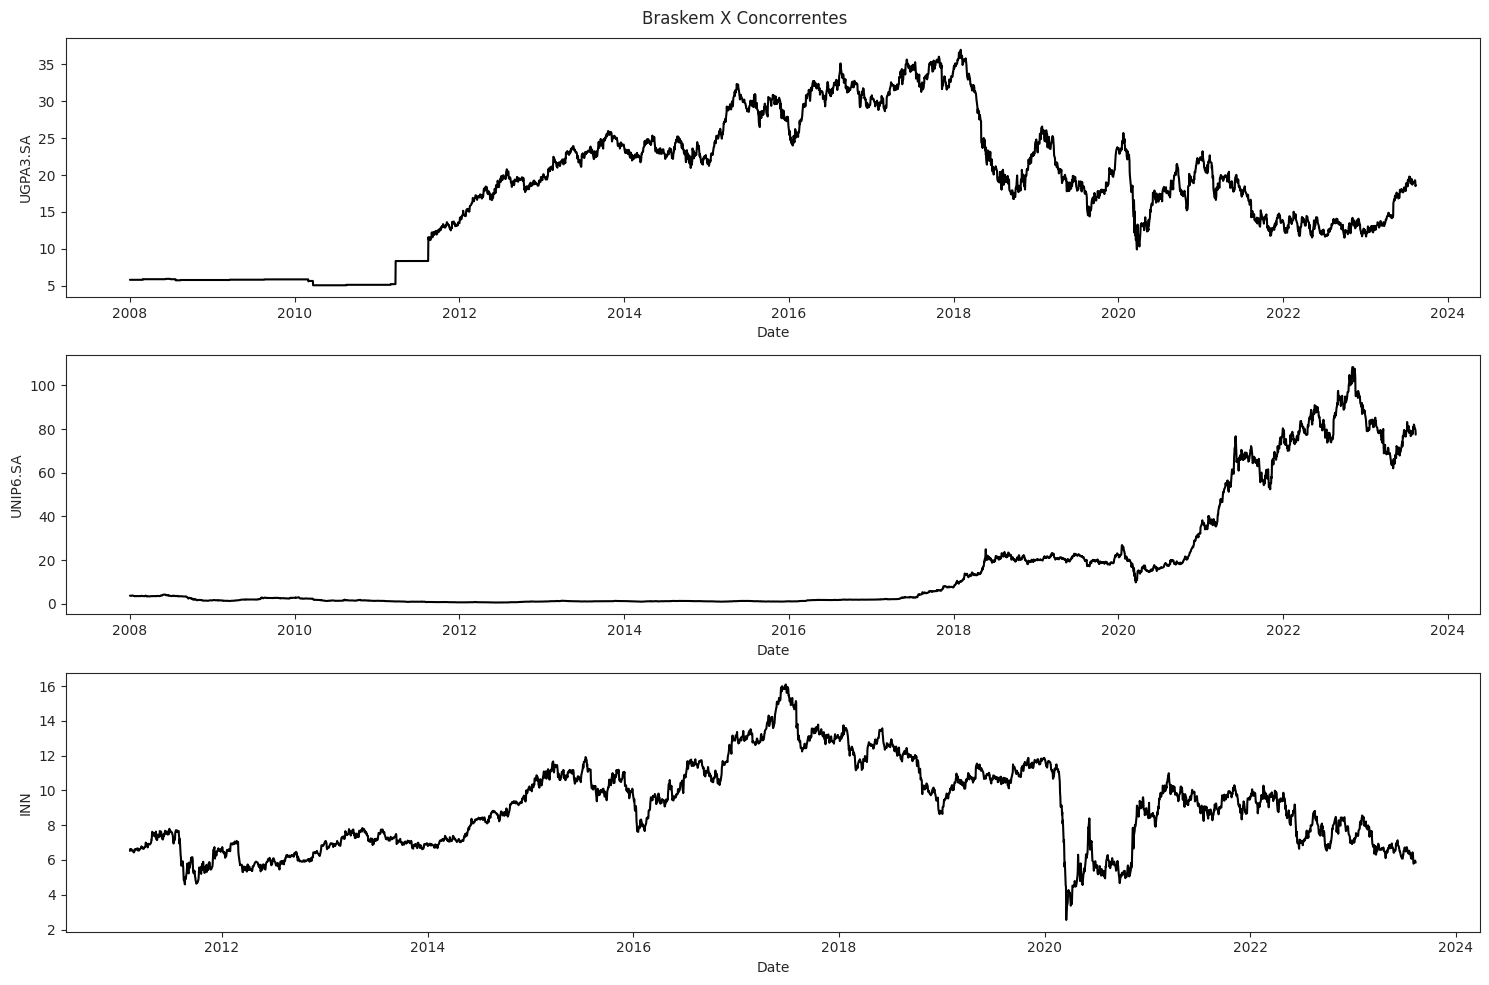

In [ ]:
#Plotando o Dataframe da Braskem
plt.figure(figsize=(15,10))
for i , col in enumerate(df_con_bras):
    ax=plt.subplot(3, 1, i+1)
    sb.lineplot(data=df_con_bras, x=df_con_bras.index, y=col, color='k')
    plt.suptitle("Braskem X Concorrentes", size="12")
    plt.tight_layout()
    plt.savefig('Braskem.png', dpi=300, bbox_inches='tight')

16. Criação do dataframe das empresas concorrentes da Vale e plotando em gráfico os resultados

In [ ]:
#Criando o dataframe da Vale
df_con_vale = df_conc[['CSN', 'RIO', 'AURA33.SA']]

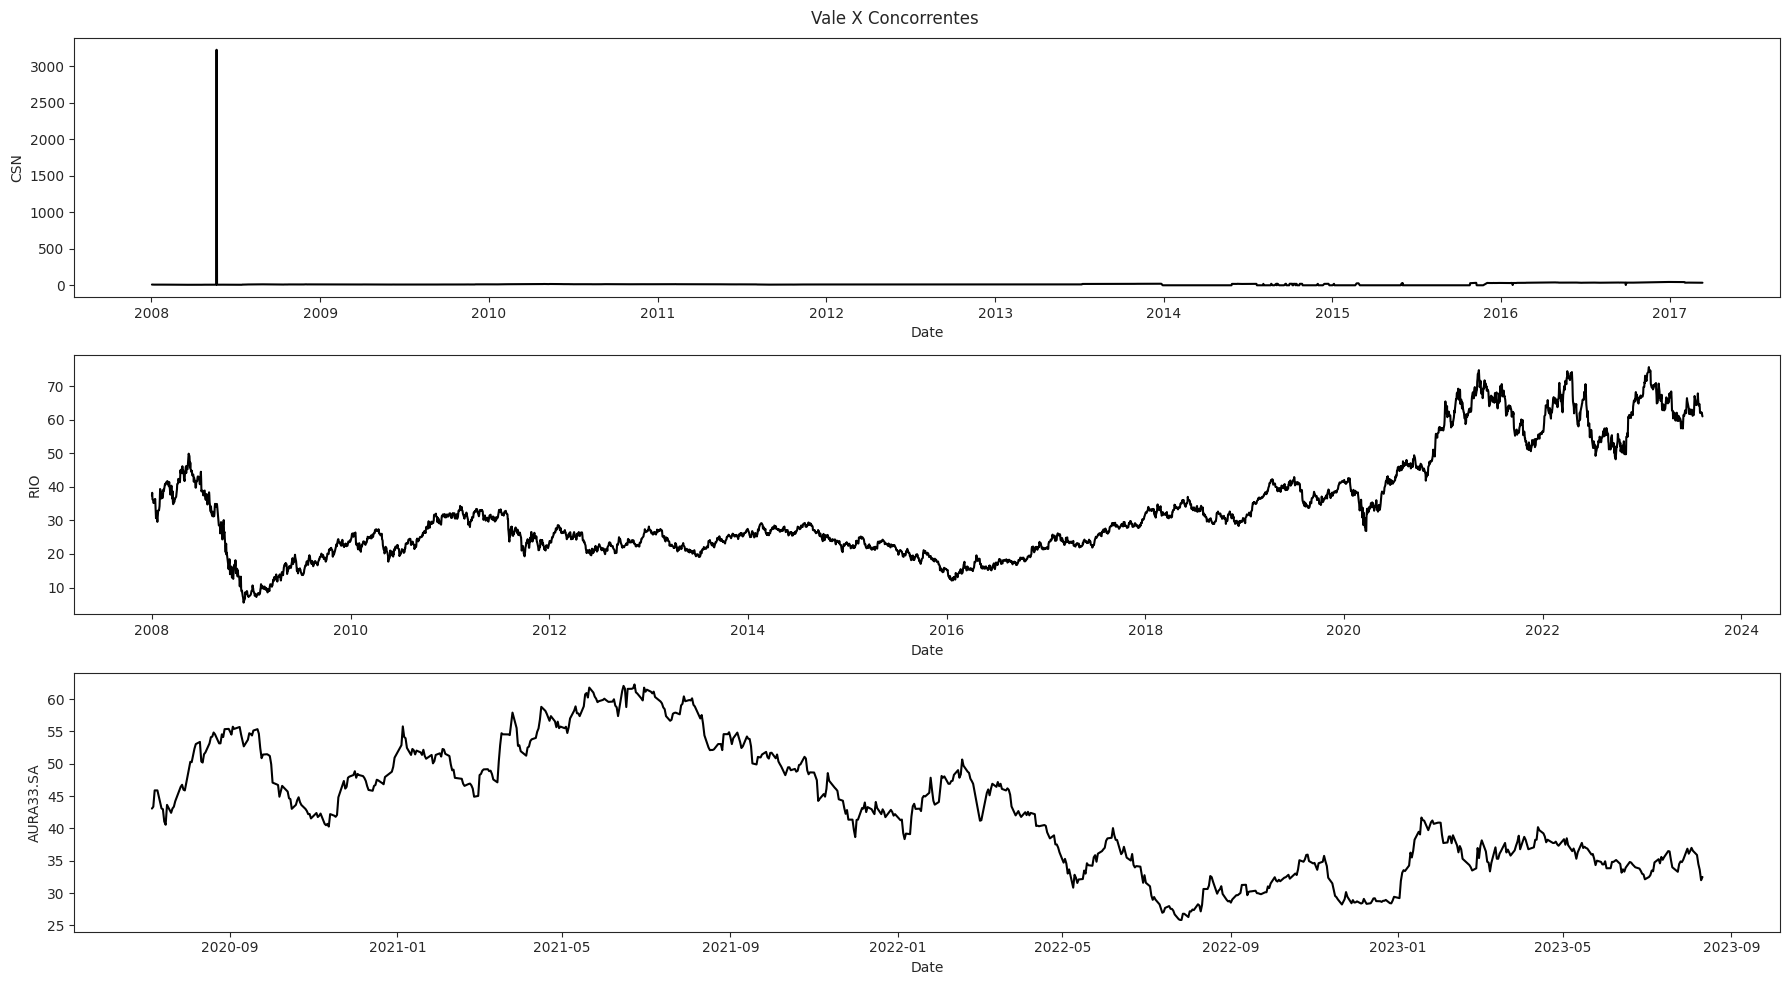

In [ ]:
#Plotando o Dataframe da Vale
plt.figure(figsize=(18,10))
for i , col in enumerate(df_con_vale):
    ax=plt.subplot(3, 1, i+1)
    sb.lineplot(data=df_con_vale, x=df_con_vale.index, y=col, color='k')
    plt.suptitle("Vale X Concorrentes", size="12")
    plt.tight_layout()
    plt.savefig('Vale.png', dpi=300, bbox_inches='tight')

17. Criação do dataframe das empresas concorrentes da Americanas e plotando em gráfico os resultados

In [ ]:
#Criando o Dataframe da Americanas
df_con_ame = df_conc[['MGLU3.SA','VIIA3.SA','CRFB3.SA']]

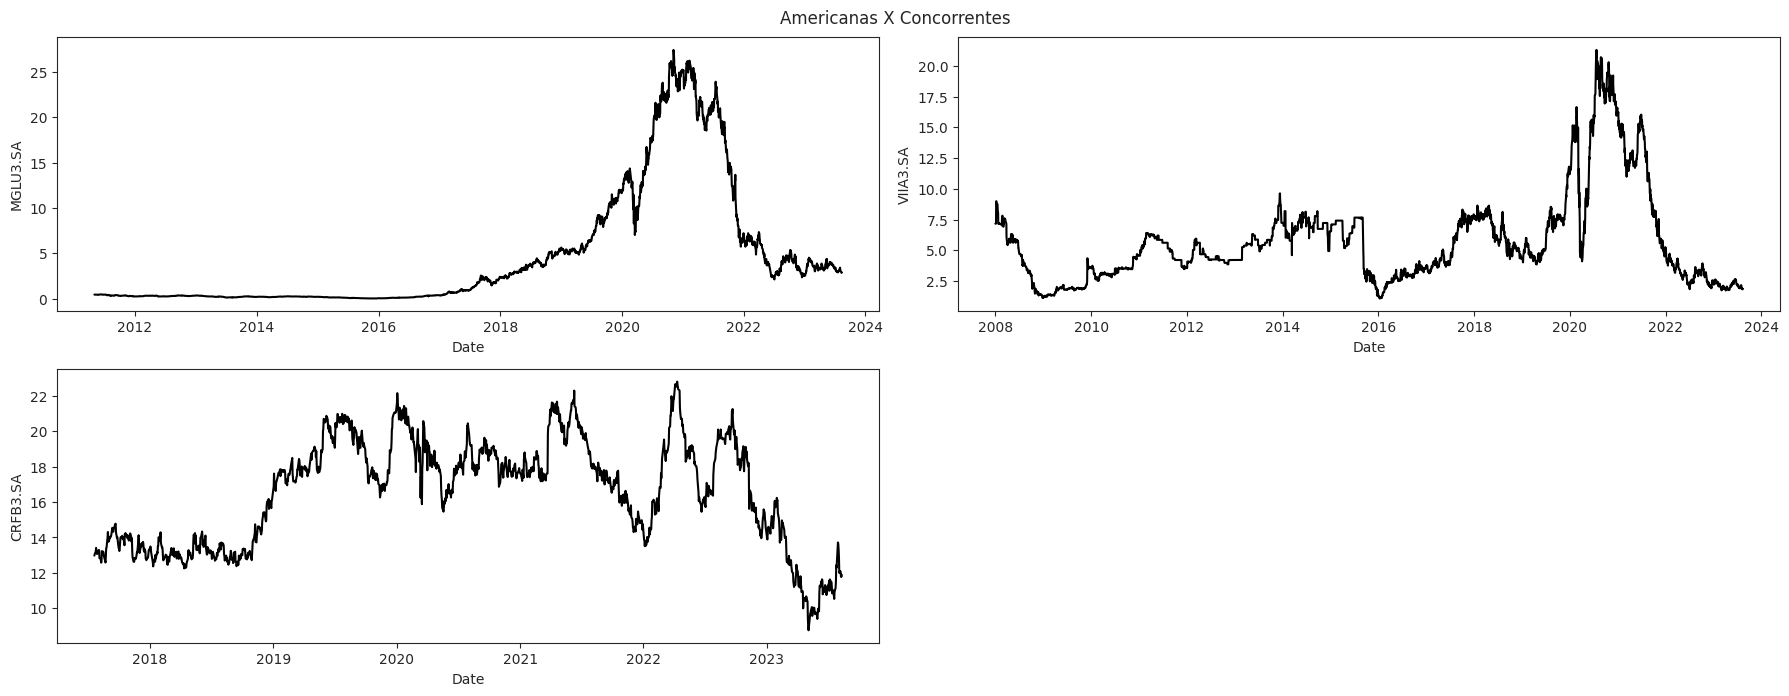

In [ ]:
#Plotando o Dataframe da Americanas
plt.figure(figsize=(18,10))
for i , col in enumerate(df_con_ame):
    ax=plt.subplot(3, 2, i+1)
    sb.lineplot(data=df_con_ame, x=df_con_ame.index, y=col, color='k')
    plt.suptitle("Americanas X Concorrentes", size="12")
    plt.tight_layout()
    plt.savefig('Americanas.png', dpi=300, bbox_inches='tight')

18. Criação do dataframe das empresas concorrentes da IRBR e plotando em gráfico os resultados

In [ ]:
#Criando o Dataframe da IRBR
df_con_irbr = df_conc[['MUV2.DE','SREN','BERK34.SA','SCR.PA', 'PSSA3.SA']]

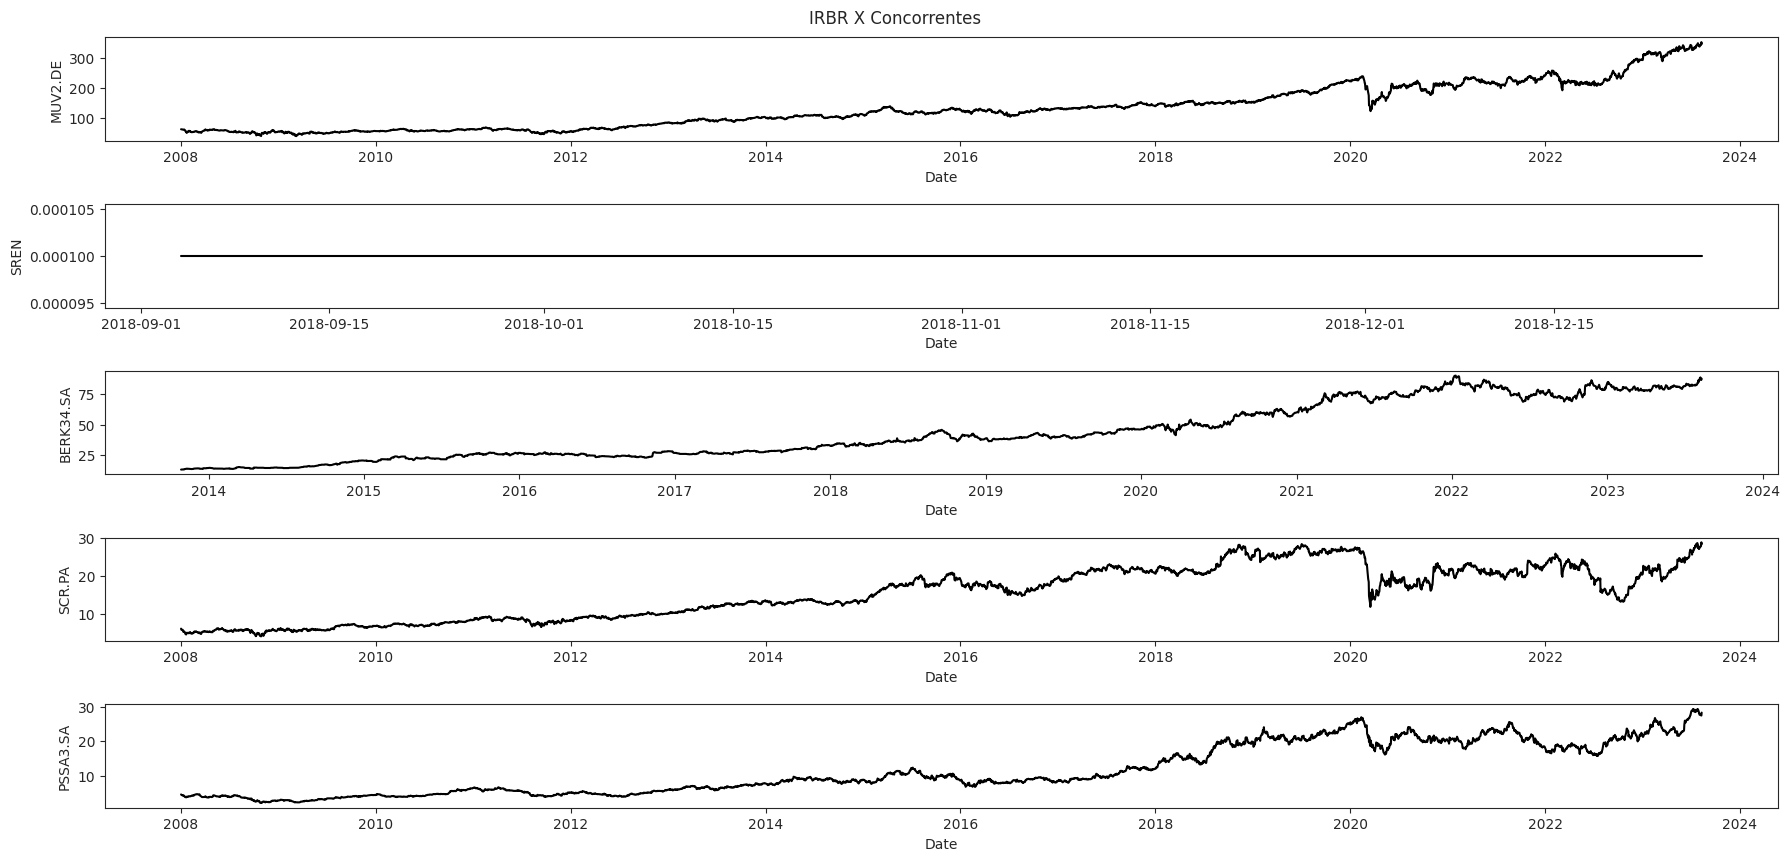

In [ ]:
#Plotando o Dataframe da IRBR
plt.figure(figsize=(18,10))
for i , col in enumerate(df_con_irbr):
    ax=plt.subplot(6, 1, i+1)
    sb.lineplot(data=df_con_irbr, x=df_con_irbr.index, y=col, color='k')
    plt.suptitle("IRBR X Concorrentes", size="12")
    plt.tight_layout()
    plt.savefig('IRBR.png', dpi=300, bbox_inches='tight')

In [ ]:
#transformando a data para datetime
df_con_irbr.index=pd.to_datetime(df_con_irbr.index)

In [ ]:
df_con_irbr.index.dtype

dtype('<M8[ns]')

19. Criação dos datasets em CSV para utilizações futuras

In [ ]:
df_con_ame.to_csv("/content/con_americanas.csv")

In [ ]:
df_con_irbr.to_csv("/content/con_irbr.csv")

In [ ]:
df_con_vale.to_csv("/content/con_vale.csv")

In [ ]:
df_con_bras.to_csv("/content/con_bras.csv")

In [ ]:
df_con_ode.to_csv("/content/con_ode.csv")

In [ ]:
df_con_petro.to_csv("/content/con_petro.csv")

In [ ]:
df_all.to_csv("/content/todas.csv")

20. Transformando as tabelas para a mesma escala e plotagem dos  gráficos

In [ ]:
#visualização da IBOVESPA e empresas com registros de crimes
df_all.tail()


,AMER3.SA,BRKM5.SA,IRBR3.SA,JBSS3.SA,PETR4.SA,VALE3.SA,Bovespa
Date,,,,,,,
2023-08-07,1.11,23.320000,39.500000,19.450001,30.190001,67.900002,NaN
2023-08-08,1.10,23.850000,38.860001,19.469999,30.219999,67.459999,NaN
2023-08-09,1.09,23.389999,38.570000,19.260000,30.459999,66.849998,NaN
2023-08-10,1.06,24.990000,39.080002,19.379999,30.629999,66.059998,NaN
2023-08-11,1.06,24.129999,39.150002,19.350000,30.559999,65.510002,NaN


###Braskem

Início em Março/2018 até a data atual.

#####O caso que envolve a Braskem e o crime ambiental refere-se principalmente aos afundamentos de solo ocorridos em bairros de Maceió, Alagoas, Brasil. Esses afundamentos foram causados por atividades de mineração subterrânea de sal-gema, realizadas pela Braskem e suas subsidiárias.

#####Os primeiros sinais de problemas geotécnicos em Maceió foram relatados a partir de 2018, quando surgiram rachaduras em edifícios e vias públicas em alguns bairros da cidade. No entanto, a situação se intensificou ao longo do tempo, culminando em uma série de afundamentos de solo em áreas residenciais, o que resultou em deslocamento de famílias e danos significativos à infraestrutura.

#####A Braskem foi acusada de contribuir para esses afundamentos devido à extração de sal-gema por meio do método de dissolução de cavernas subterrâneas, que, segundo alegações, causou o colapso do subsolo e a formação de crateras. Essas atividades levaram a um desastre ambiental significativo.


In [ ]:
df_con_bras.index=pd.to_datetime(df_con_bras.index)

In [ ]:
df_con_bras=pd.merge(df_bovespa, df_con_bras, how="left", left_index=True, right_index=True)


In [ ]:
df_con_bras=pd.merge(df_con_bras,df_BRKM5, how="left", left_index=True, right_index=True)


In [ ]:
df_con_bras.dtypes

Bovespa     float64
UGPA3.SA    float64
UNIP6.SA    float64
INN         float64
BRKM5.SA    float64
dtype: object

In [ ]:
df_con_bras.fillna(0)

,Bovespa,UGPA3.SA,UNIP6.SA,INN,BRKM5.SA
Date,,,,,
2006-01-02,33507.0,0.000000,0.000000,0.00,0.00
2006-01-03,34541.0,0.000000,0.000000,0.00,0.00
2006-01-04,35002.0,0.000000,0.000000,0.00,0.00
2006-01-05,34936.0,0.000000,0.000000,0.00,0.00
2006-01-06,35475.0,0.000000,0.000000,0.00,0.00
...,...,...,...,...,...
2023-07-24,121342.0,19.459999,78.430000,6.25,25.08
2023-07-25,122008.0,19.320000,78.000000,6.15,25.65
2023-07-26,122560.0,18.969999,79.050003,6.14,25.35


In [ ]:
#definicao da janela temporal que vai ser trabalhada
df_con_bras=df_con_bras.loc["2016-01-01":]

In [ ]:
#xxx_xxx_time_xx_perc-> referente a janela temporal do data crime
df_con_bras_time_perc=df_con_bras.loc["2018-02-21":].pct_change() *100

df_con_bras_time_perc.head()

df_con_bras_time_perc.sort_index(ascending=True)



df_con_bras_time_perc.to_csv("/content/df_con_bras_time_perc.csv")

In [ ]:
#Trazendo a media movel para 90 dias usando o rolling().mean()

df_con_bras["UGPA3.SA_return"]=df_con_bras["UGPA3.SA"].rolling('252D').mean()
df_con_bras["UNIPA.SA_return"]=df_con_bras["UNIP6.SA"].rolling('252D').mean()
df_con_bras["INN.SA_return"]=df_con_bras["INN"].rolling('252D').mean()
df_con_bras["BRKM5.SA_return"]=df_con_bras["BRKM5.SA"].rolling('252D').mean()
df_con_bras["Bov_return"]=df_con_bras["Bovespa"].rolling('252D').mean()


df_con_bras.tail()

<ipython-input-72-e7c1e181d626>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_con_bras["UGPA3.SA_return"]=df_con_bras["UGPA3.SA"].rolling('252D').mean()
<ipython-input-72-e7c1e181d626>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_con_bras["UNIPA.SA_return"]=df_con_bras["UNIP6.SA"].rolling('252D').mean()
<ipython-input-72-e7c1e181d626>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

,Bovespa,UGPA3.SA,UNIP6.SA,INN,BRKM5.SA,UGPA3.SA_return,UNIPA.SA_return,INN.SA_return,BRKM5.SA_return,Bov_return
Date,,,,,,,,,,
2023-07-24,121342.0,19.459999,78.430000,6.25,25.08,14.785555,78.551837,7.136556,23.412849,109377.441860
2023-07-25,122008.0,19.320000,78.000000,6.15,25.65,14.811766,78.548647,7.130613,23.425780,109450.450867
2023-07-26,122560.0,18.969999,79.050003,6.14,25.35,14.847511,78.405775,7.119593,23.397977,109521.647399
2023-07-27,119990.0,18.700001,77.570000,6.07,24.51,14.880261,78.291075,7.107973,23.368150,109581.109827
2023-07-28,120187.0,18.879999,77.529999,6.34,24.57,14.913994,78.189964,7.095306,23.340809,109646.468208


In [ ]:
df_con_bras_pct=df_con_bras.pct_change().fillna(0)

In [ ]:
df_con_bras_pct_return=(((1 + df_con_bras_pct).cumprod()-1)*100)+100

df_con_bras_pct_return.to_csv("/content/df_con_bras_apresentacao.csv")

In [ ]:
df_con_bras_pct_return_bras=df_con_bras_pct_return[["BRKM5.SA_return",	"Bov_return"]]

In [ ]:
target_date_str = "2018-03-03"
target_date = dt.strptime(target_date_str, "%Y-%m-%d")  # Use %Y instead of %YYY


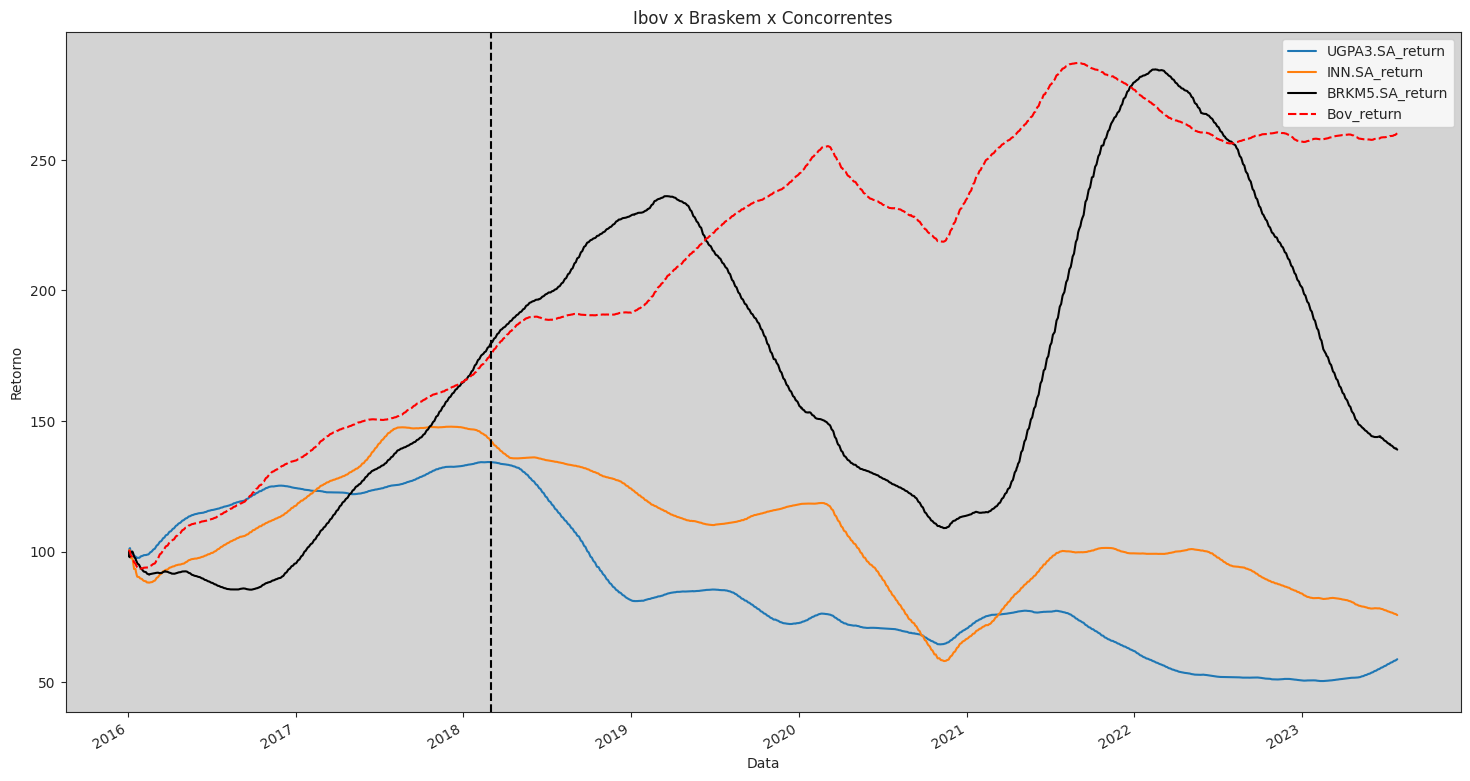

In [ ]:

ax = (df_con_bras_pct_return[["UGPA3.SA_return","INN.SA_return"]].plot(figsize=(18, 10)))
sb.lineplot(data=df_con_bras_pct_return_bras, palette=["black","red"])
ax.set_facecolor("lightgrey")
ax.set_ylabel("Retorno")
ax.set_xlabel("Data")
ax.axvline(x=target_date, color="black", linestyle="--")
ax.set_facecolor("lightgrey")
ax.set_title("Ibov x Braskem x Concorrentes")

ax.figure.savefig('df_con_bras_pct_return.jpeg', dpi=600)



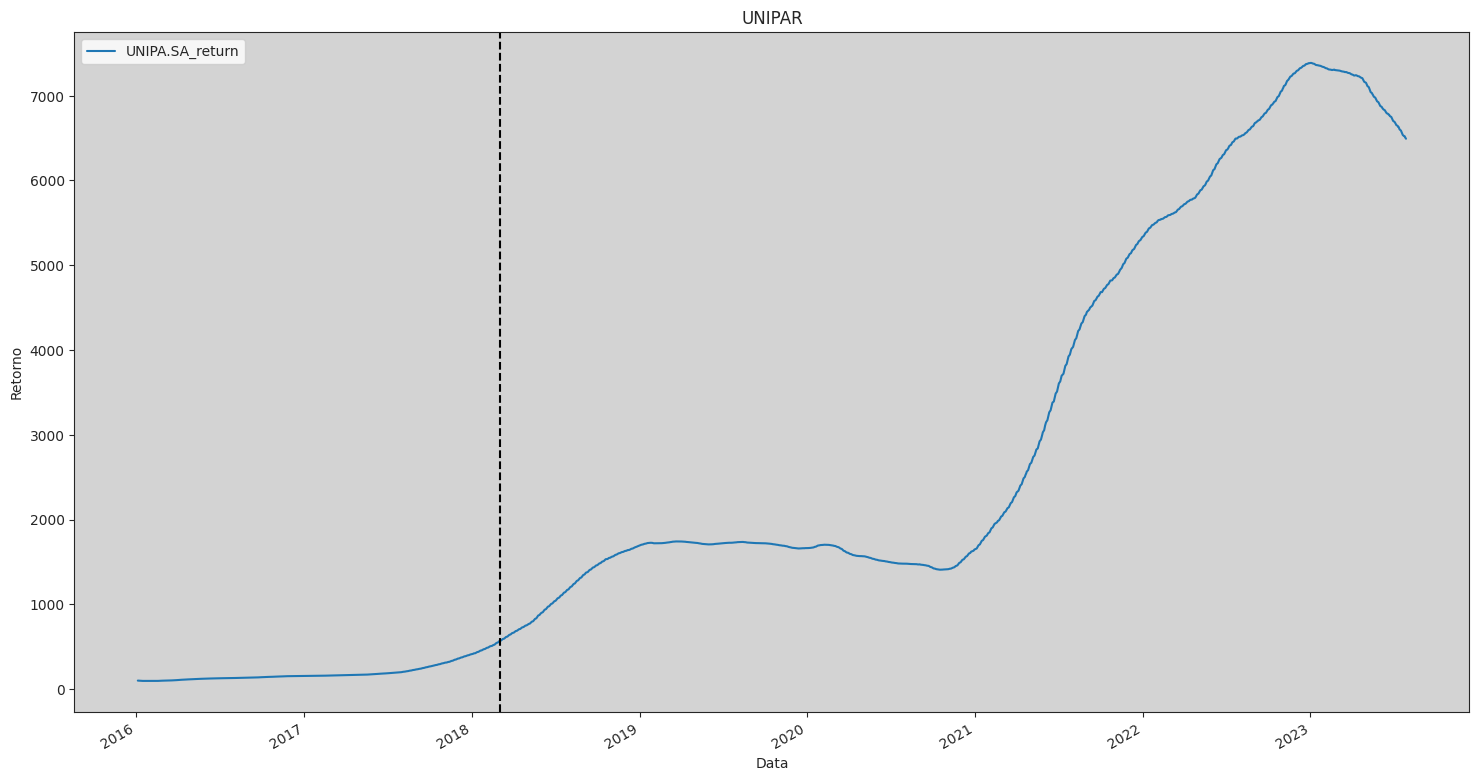

In [ ]:
ax = df_con_bras_pct_return["UNIPA.SA_return"].plot(figsize=(18, 10))

ax.set_facecolor("lightgrey")
ax.set_ylabel("Retorno")
ax.set_xlabel("Data")
ax.legend( loc="best")
ax.set_facecolor("lightgrey")
ax.set_title("UNIPAR")
ax.axvline(x=target_date, color="black", linestyle="--")

ax.figure.savefig('df_con_unipar_pct_return.jpeg', dpi=600)

# VALE

Início em 2019 até o atual momento

O crime ambiental envolvendo a empresa brasileira Vale refere-se ao rompimento da barragem de rejeitos de mineração em Brumadinho, Minas Gerais, em janeiro de 2019. Esse desastre resultou em uma tragédia humana e ambiental de grande escala.

No rompimento da barragem, uma enorme quantidade de resíduos tóxicos e lama foram liberados, causando destruição a áreas residenciais, poluição de rios e danos ambientais significativos. Centenas de pessoas perderam suas vidas, muitas comunidades foram devastadas e o ecossistema local sofreu danos graves.

A Vale, proprietária da barragem, foi acusada de negligência na manutenção e monitoramento da estrutura, o que levou ao colapso. Houve questionamentos sobre a segurança das operações de mineração e gerenciamento de rejeitos da empresa.

O desastre de Brumadinho gerou debates sobre regulamentações ambientais, fiscalização de empresas e a responsabilidade do setor privado na prevenção de acidentes desse tipo. A Vale enfrentou ações judiciais, multas e pressão pública por sua responsabilidade no desastre e por danos causados ao meio ambiente e às vidas humanas

In [ ]:
df_con_vale=pd.merge(df_con_vale,df_vale, how="left", left_index=True, right_index=True)


In [ ]:
df_con_vale=pd.merge(df_con_vale, df_bovespa,how="left", left_index=True, right_index=True )


In [ ]:
df_con_vale.index=pd.to_datetime(df_con_vale.index)


* Seleção da janela temporal de 2017 ate atual momento

In [ ]:
df_con_vale=df_con_vale.loc["2017-01-01":"2023-07-29"]
df_con_vale.head(10)


,CSN,RIO,AURA33.SA,VALE3.SA,Bovespa
Date,,,,,
2017-01-02,NaN,NaN,NaN,16.365667,59589.0
2017-01-03,45.250000,21.850271,NaN,17.090567,61814.0
2017-01-04,45.770000,21.990484,NaN,16.783628,61589.0
2017-01-05,46.595001,22.052177,NaN,17.423626,62071.0
2017-01-06,46.320000,21.530596,NaN,16.959955,61665.0
2017-01-09,46.580002,21.513773,NaN,17.306076,61700.0
2017-01-10,46.435001,22.994385,NaN,18.638317,62132.0
2017-01-11,46.250000,23.386971,NaN,19.023619,62446.0
2017-01-12,NaN,23.628136,NaN,19.637499,63954.0


In [ ]:
df_con_vale.drop(columns="CSN", inplace=True)

In [ ]:
df_con_vale_time_perc=df_con_vale.loc["2019-01-18":].pct_change() *100

df_con_vale_time_perc.head()

df_con_vale_time_perc.sort_index(ascending=True)



df_con_vale_time_perc

#df_con_vale_time_perc.to_csv("/content/df_con_vale_time_perc.csv")

,RIO,AURA33.SA,VALE3.SA,Bovespa
Date,,,,
2019-01-18,NaN,NaN,NaN,NaN
2019-01-21,0.000000,NaN,0.949610,-0.090534
2019-01-22,-2.575521,NaN,-0.361795,-0.944693
2019-01-23,-0.775213,NaN,1.034861,1.529920
2019-01-24,-0.100142,NaN,0.898454,1.158889
...,...,...,...,...
2023-07-24,0.827311,-1.566664,3.023592,0.935808
2023-07-25,4.147393,3.603606,3.092346,0.548862
2023-07-26,-2.664378,1.159425,-0.347174,0.452429


In [ ]:
#Trazendo a media movel para 90 dias usando o rolling().mean()

df_con_vale["RIO_return"]=df_con_vale["RIO"].rolling('90D').mean()
df_con_vale["AURA33.SA_return"]=df_con_vale["AURA33.SA"].rolling('90D').mean()
df_con_vale["VALE3.SA_return"]=df_con_vale["VALE3.SA"].rolling('90D').mean()
df_con_vale["Bov_return"]=df_con_vale["Bovespa"].rolling('90D').mean()

In [ ]:
df_con_vale_pct=df_con_vale.pct_change().fillna(0)
df_con_vale_pct

,RIO,AURA33.SA,VALE3.SA,Bovespa,RIO_return,AURA33.SA_return,VALE3.SA_return,Bov_return
Date,,,,,,,,
2017-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-03,0.000000,0.000000,0.044294,0.037339,0.000000,0.000000,0.022147,0.018670
2017-01-04,0.006417,0.000000,-0.017960,-0.003640,0.003208,0.000000,0.001106,0.004874
2017-01-05,0.002805,0.000000,0.038132,0.007826,0.002004,0.000000,0.010107,0.004400
2017-01-06,-0.023652,0.000000,-0.026612,-0.006541,-0.004937,0.000000,0.000521,0.001303
...,...,...,...,...,...,...,...,...
2023-07-24,0.008273,-0.015667,0.030236,0.009358,0.001078,-0.003194,-0.001070,0.003893
2023-07-25,0.041474,0.036036,0.030923,0.005489,0.001764,-0.001591,0.000415,0.002797
2023-07-26,-0.026644,0.011594,-0.003472,0.004524,0.001090,-0.001225,0.000000,0.002781


In [ ]:
df_con_vale_pct_return=(((1 + df_con_vale_pct).cumprod()-1)*100)+100

In [ ]:
df_con_vale_pct_return.to_csv("/content/df_con_vale_apresentacao.csv")

In [ ]:
df_con_vale_pct_return_vale=df_con_vale_pct_return[["VALE3.SA_return",	"Bov_return"]]

In [ ]:
df_con_vale_pct_return[["VALE3.SA_return",	"Bov_return"]]

,VALE3.SA_return,Bov_return
Date,,
2017-01-02,100.000000,100.000000
2017-01-03,102.214695,101.866955
2017-01-04,102.327760,102.363412
2017-01-05,103.361945,102.813858
2017-01-06,103.415818,102.947860
...,...,...
2023-07-24,412.766155,190.595363
2023-07-25,412.937640,191.128477
2023-07-26,412.937640,191.659995


In [ ]:
target_date_str = "2019-01-25"
target_date = dt.strptime(target_date_str, "%Y-%m-%d")  # Use %Y instead of %YYY

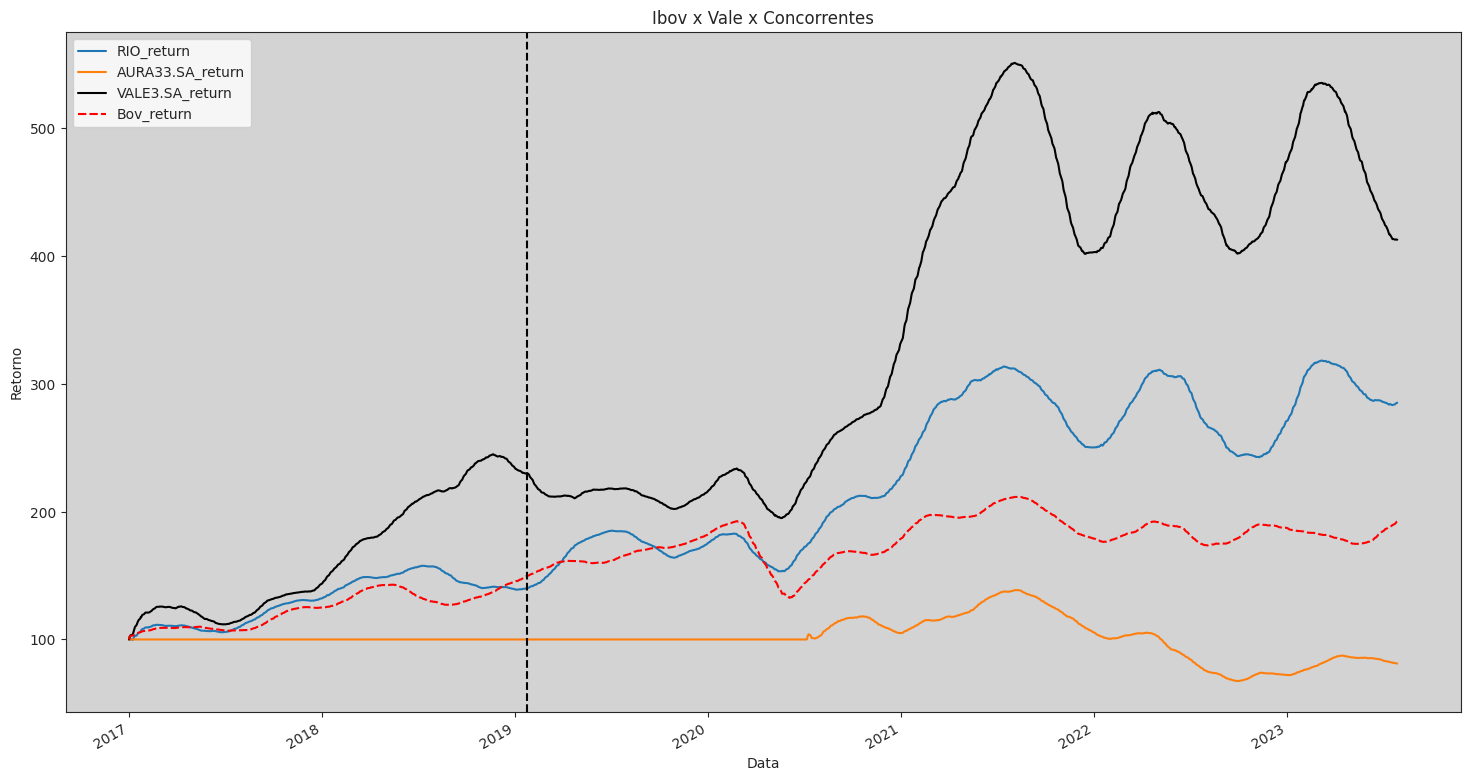

In [ ]:
ax = (df_con_vale_pct_return[["RIO_return","AURA33.SA_return"]].plot(figsize=(18, 10)))
sb.lineplot(data=df_con_vale_pct_return_vale, palette=["black","red"])
ax.set_facecolor("lightgrey")
ax.set_ylabel("Retorno")
ax.set_xlabel("Data")
ax.axvline(x=target_date, color="black", linestyle="--")
ax.set_facecolor("lightgrey")
ax.set_title("Ibov x Vale x Concorrentes")
ax.figure.savefig('df_con_vale_pct_return.jpeg', dpi=600)

# Petrobras


Início em 17/04/2014 até 01/02/2021.

O caso "Petrolão", também conhecido como "Operação Lava Jato", é um escândalo de corrupção que veio à tona em março de 2014, envolvendo a empresa estatal brasileira Petrobras. A investigação revelou um extenso esquema de corrupção em que empreiteiras pagavam propinas a executivos da Petrobras em troca de contratos lucrativos. Essas propinas eram então distribuídas a políticos e partidos, envolvendo uma rede complexa de corrupção.

A "Operação Lava Jato" resultou em prisões de executivos de empresas, políticos influentes e figuras ligadas à Petrobras. Ela provocou uma ampla investigação que abrangeu múltiplos setores da sociedade brasileira. O escândalo teve impacto significativo na economia e na política do Brasil, gerando debates sobre corrupção sistêmica, ética no setor público e a necessidade de reformas profundas.

O caso Petrobras, ao longo dos anos, desdobrou-se em diversas fases, julgamentos e processos legais, culminando em condenações de diversas pessoas envolvidas. Sua magnitude e implicações fizeram dele um dos maiores escândalos de corrupção da história do Brasil.

In [ ]:
#Puxando o dataset atraves do CSV
df_petrotest=pd.read_csv("/content/PBR.csv", usecols=["Close", "Date"])
df_petrotest.head()
df_petrotest["Date"]=pd.to_datetime(df_petrotest["Date"])
df_petrotest=df_petrotest.set_index("Date")
df_petrotest.columns=["Petro"]

In [ ]:
#unindo dataframe da Petrobras com os concorrentes
df_con_petro=pd.merge(df_petrotest, df_con_petro, how="left", left_index=True, right_index=True)

In [ ]:
#unindo o dataframe dos concorrentes e pretrobras + IBOVESPA
df_con_petro=pd.merge(df_con_petro, df_bovespa, how="left", left_index=True, right_index=True)

In [ ]:
#transformando o data para datetime
df_con_petro.index=pd.to_datetime(df_con_petro.index)


In [ ]:
#certificando que a conversao foi realizada de maneira correta
df_con_petro.index.dtype

dtype('<M8[ns]')

In [ ]:
df_con_petro.loc["2014-03-10":"2016-03-10"]

,Petro,SHEL,EQNR,XOM,CVX,BZ=F,Bovespa
Date,,,,,,,
2014-03-10,10.68,44.093662,17.385777,63.644711,78.360626,108.080002,45533.0
2014-03-11,10.54,43.780445,17.353790,62.651741,77.460968,108.550003,45698.0
2014-03-12,10.69,43.629845,17.347397,62.785034,78.232094,108.019997,45862.0
2014-03-13,10.54,42.798580,17.360188,62.405151,77.420349,107.389999,45444.0
2014-03-14,10.37,42.991337,17.622444,62.291847,77.183601,108.570000,44966.0
...,...,...,...,...,...,...,...
2016-03-04,5.26,32.639980,11.230845,58.446159,64.638069,38.720001,49085.0
2016-03-07,5.22,32.830425,11.280379,59.987408,66.652290,40.840000,49246.0
2016-03-08,5.07,32.048260,10.756699,58.687645,65.233528,39.650002,49102.0


In [ ]:
#corte da janela temporal  data crime + 2 anos para aprensetacao de resultados

df_con_petro_time_perc=df_con_petro.loc["2014-03-10":"2016-03-10"].pct_change() *100

df_con_petro_time_perc.head()

df_con_petro_time_perc

df_con_petro_time_perc.to_csv("/content/df_con_petro_time_perc.csv")


In [ ]:
#separando dataframe para analise ( 2 anos antes da data crime)

df_con_petro=df_con_petro.loc["2012-01-01":"2021-02-01"]

In [ ]:
#atribuindo nova coluna para media movel de 90 dias suavizando o grafico

df_con_petro["SHEL_return"]=df_con_petro["SHEL"].rolling('90D').mean()

df_con_petro["EQNR_return"]=df_con_petro["EQNR"].rolling('90D').mean()

df_con_petro["XOM_return"]=df_con_petro["XOM"].rolling('90D').mean()

df_con_petro["CVX	_return"]=df_con_petro["CVX"].rolling('90D').mean()

df_con_petro["PETRO_BRENT_return"]=df_con_petro["BZ=F"].rolling('90D').mean()

df_con_petro["PETRO_return"]=df_con_petro["Petro"].rolling('90D').mean()

df_con_petro["Bov_return"]=df_con_petro["Bovespa"].rolling('90D').mean()

In [ ]:
#visualizando o dataset com os devidos incrementos de colunas

df_con_petro.head()

,Petro,SHEL,EQNR,XOM,CVX,BZ=F,Bovespa,SHEL_return,EQNR_return,XOM_return,CVX\t_return,PETRO_BRENT_return,PETRO_return,Bov_return
Date,,,,,,,,,,,,,,
2012-01-03,26.110001,39.834358,15.553388,54.028168,69.309074,112.129997,59265.0,39.834358,15.553388,54.028168,69.309074,112.129997,26.110001,59265.000000
2012-01-04,26.459999,39.861191,15.292231,54.040752,69.189781,113.699997,59365.0,39.847775,15.422809,54.034460,69.249428,112.914997,26.285000,59315.000000
2012-01-05,26.110001,39.158112,15.077502,53.877396,68.511566,112.739998,58546.0,39.617887,15.307707,53.982105,69.003474,112.856664,26.226667,59058.666667
2012-01-06,25.690001,39.587479,14.967235,53.475319,68.015450,113.059998,58600.0,39.610285,15.222589,53.855409,68.756468,112.907497,26.092500,58944.000000
2012-01-09,26.879999,39.705547,15.054293,53.714066,68.756470,112.449997,59083.0,39.629337,15.188930,53.827140,68.756468,112.815997,26.250000,58971.800000


In [ ]:
df_con_petro_pct=df_con_petro.pct_change().fillna(0)

In [ ]:
df_con_petro_pct_return=round((((1 + df_con_petro_pct).cumprod()-1)*100),2)+100

df_con_petro_pct_return.to_csv("/content/df_con_petro_time_perc.csv")

In [ ]:
df_con_petro_pct_return_petro=df_con_petro_pct_return[["PETRO_return","Bov_return"]]

In [ ]:
target_date_str = "2014-03-17"
target_date = dt.strptime(target_date_str, "%Y-%m-%d")  # Use %Y instead of %YYY


<ipython-input-107-400908d3817a>:10: UserWarning: Glyph 9 (	) missing from current font.
  ax.figure.savefig('df_con_petro_pct_return.jpeg', dpi=600)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


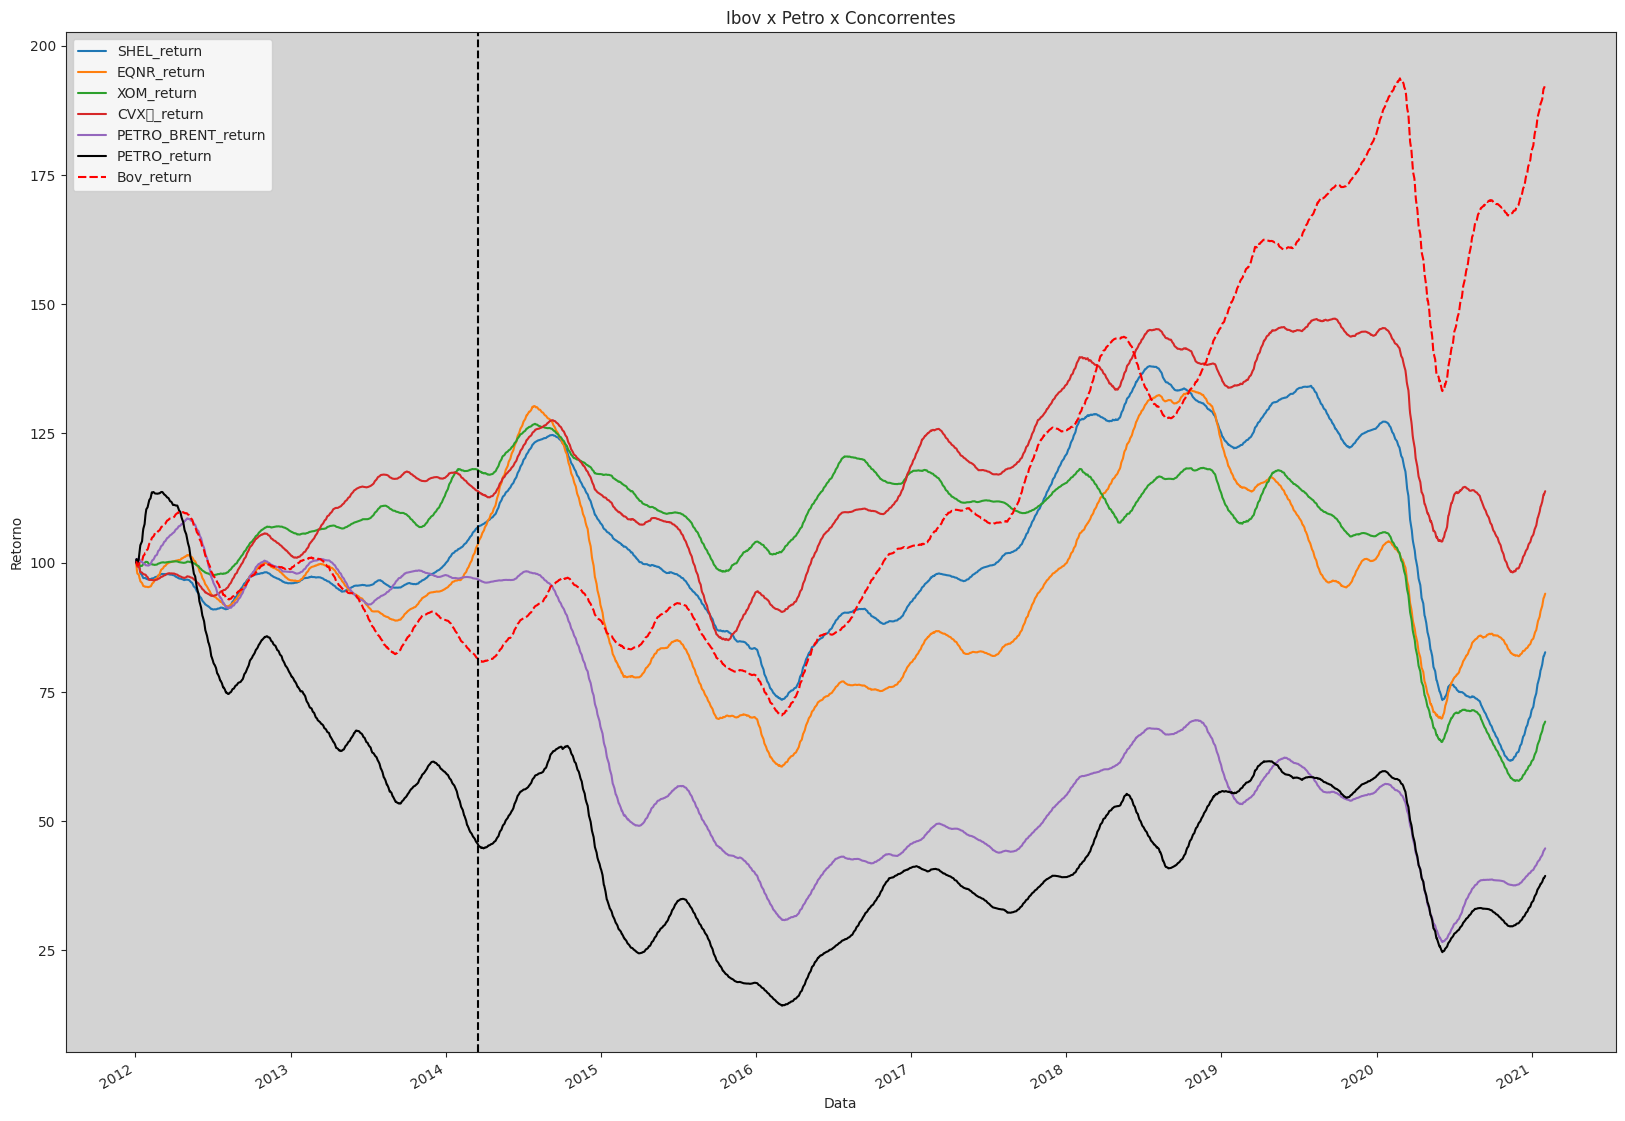

In [ ]:
ax=(df_con_petro_pct_return[["SHEL_return",	"EQNR_return",	"XOM_return","CVX\t_return"
,"PETRO_BRENT_return"]].plot(figsize=(20, 15)))
sb.lineplot(data=df_con_petro_pct_return_petro, palette=["black", "red"])
ax.set_ylabel("Retorno")
ax.set_xlabel("Data")
ax.axvline(x=target_date, color="black", linestyle="--")
ax.set_title("Ibov x Petro x Concorrentes")
ax.set_facecolor("lightgrey")

ax.figure.savefig('df_con_petro_pct_return.jpeg', dpi=600)

# IRBR

Início em 2020 sem data fim declarada

O caso envolvendo a IRB Brasil Resseguros (IRBR) refere-se a irregularidades financeiras e contábeis descobertas na empresa. A IRBR é uma resseguradora brasileira listada na Bolsa de Valores.

No início de 2020, veio à tona que a empresa havia inflado seu lucro líquido e seus resultados financeiros em anos anteriores por meio de práticas contábeis questionáveis. Essas práticas envolviam a manipulação de reservas técnicas e outros números contábeis para criar uma aparência falsa de crescimento e lucratividade mais alta do que a realidade.

As denúncias causaram um impacto significativo nas ações da IRBR e geraram desconfiança nos mercados financeiros e no público em geral. Isso levou a uma queda substancial no valor de mercado da empresa e a investigações por parte das autoridades reguladoras e órgãos de controle.

O caso da IRBR ressalta a importância da transparência, governança corporativa e auditorias rigorosas nas práticas financeiras das empresas. Ele também destaca as consequências negativas que práticas contábeis fraudulentas podem ter sobre a reputação e a confiança dos investidores e do público em uma empresa.


In [ ]:
##unindo dataframe da IRBR com os concorrentes
df_con_irbr=pd.merge(df_con_irbr, df_IRBR3, how="left", left_index=True, right_index=True)

In [ ]:
#unindo dataframe da Petrobras com Ibovespa
df_con_irbr=pd.merge(df_con_irbr, df_bovespa, how="left", left_index=True, right_index=True)

In [ ]:
#transformando index para datetime
df_con_irbr.index=pd.to_datetime(df_con_irbr.index)

In [ ]:
#selecionando 2 anos antes da data crime
df_con_irbr=df_con_irbr.loc["2018-01-01":]

In [ ]:
df_con_irbr.head(1)

,MUV2.DE,SREN,BERK34.SA,SCR.PA,PSSA3.SA,IRBR3.SA,Bovespa
Date,,,,,,,
2018-01-02,139.960861,NaN,32.215,20.56245,12.104671,253.553757,77891.0


In [ ]:
#janela temporal 1 semana para antes da data crime
df_con_irbr_time_perc=df_con_irbr.loc["2020-02-01":].pct_change()*100


df_con_irbr_time_perc.sort_index(ascending=True)

df_con_irbr_time_perc.head()

df_con_irbr_time_perc.to_csv("/content/df_con_irbr_time_perc.csv")


In [ ]:
df_con_irbr["MUV2_return"]=df_con_irbr["MUV2.DE"].rolling('90D').mean()
df_con_irbr["SREN_return"]=df_con_irbr["SREN"].rolling('90D').mean()
df_con_irbr["BERK34.SA_return"]=df_con_irbr["BERK34.SA"].rolling('90D').mean()
df_con_irbr["SCR.PA_return"]=df_con_irbr["SCR.PA"].rolling('90D').mean()
df_con_irbr["PSSA3.SA_return"]=df_con_irbr["PSSA3.SA"].rolling('90D').mean()
df_con_irbr["IRBR3.SA_return"]=df_con_irbr["IRBR3.SA"].rolling('90D').mean()
df_con_irbr["Bov_return"]=round(df_con_irbr["Bovespa"].rolling('90D').mean(),2)

In [ ]:
df_con_irbr_pct=df_con_irbr.pct_change().fillna(0)

In [ ]:
df_con_irbr_pct_return=round((((1 + df_con_irbr_pct).cumprod()-1)*100),2)+100

In [ ]:
df_con_irbr_pct_return

,MUV2.DE,SREN,BERK34.SA,SCR.PA,PSSA3.SA,IRBR3.SA,Bovespa,MUV2_return,SREN_return,BERK34.SA_return,SCR.PA_return,PSSA3.SA_return,IRBR3.SA_return,Bov_return
Date,,,,,,,,,,,,,,
2018-01-02,100.00,100.0,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.00
2018-01-03,100.72,100.0,100.43,100.75,101.81,100.00,100.13,100.36,100.0,100.22,100.38,100.91,100.00,100.07
2018-01-04,102.41,100.0,101.46,102.58,101.90,100.86,100.97,101.05,100.0,100.63,101.11,101.24,100.29,100.37
2018-01-05,102.52,100.0,100.51,104.29,103.87,102.17,101.51,101.42,100.0,100.60,101.91,101.90,100.76,100.65
2018-01-08,102.97,100.0,101.79,102.97,103.35,103.83,101.91,101.73,100.0,100.84,102.12,102.19,101.37,100.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-07,244.35,100.0,274.87,134.71,229.91,15.58,154.30,238.65,100.0,253.91,124.73,215.53,16.31,148.49
2023-08-08,245.00,100.0,276.21,135.10,227.93,15.33,154.30,238.84,100.0,254.36,125.17,216.15,16.33,148.67
2023-08-09,246.57,100.0,272.51,136.90,226.94,15.21,154.30,239.08,100.0,254.76,125.63,216.75,16.35,148.85


In [ ]:
df_con_irbr_pct_return.to_csv("/content/df_con_irbr_apresentacao.csv")

In [ ]:
df_con_irbr_pct_return_irbr=df_con_irbr_pct_return[["IRBR3.SA_return","Bov_return"]]

In [ ]:
target_date_str = "2020-02-08"
target_date = dt.strptime(target_date_str, "%Y-%m-%d")  # Use %Y instead of %YYY

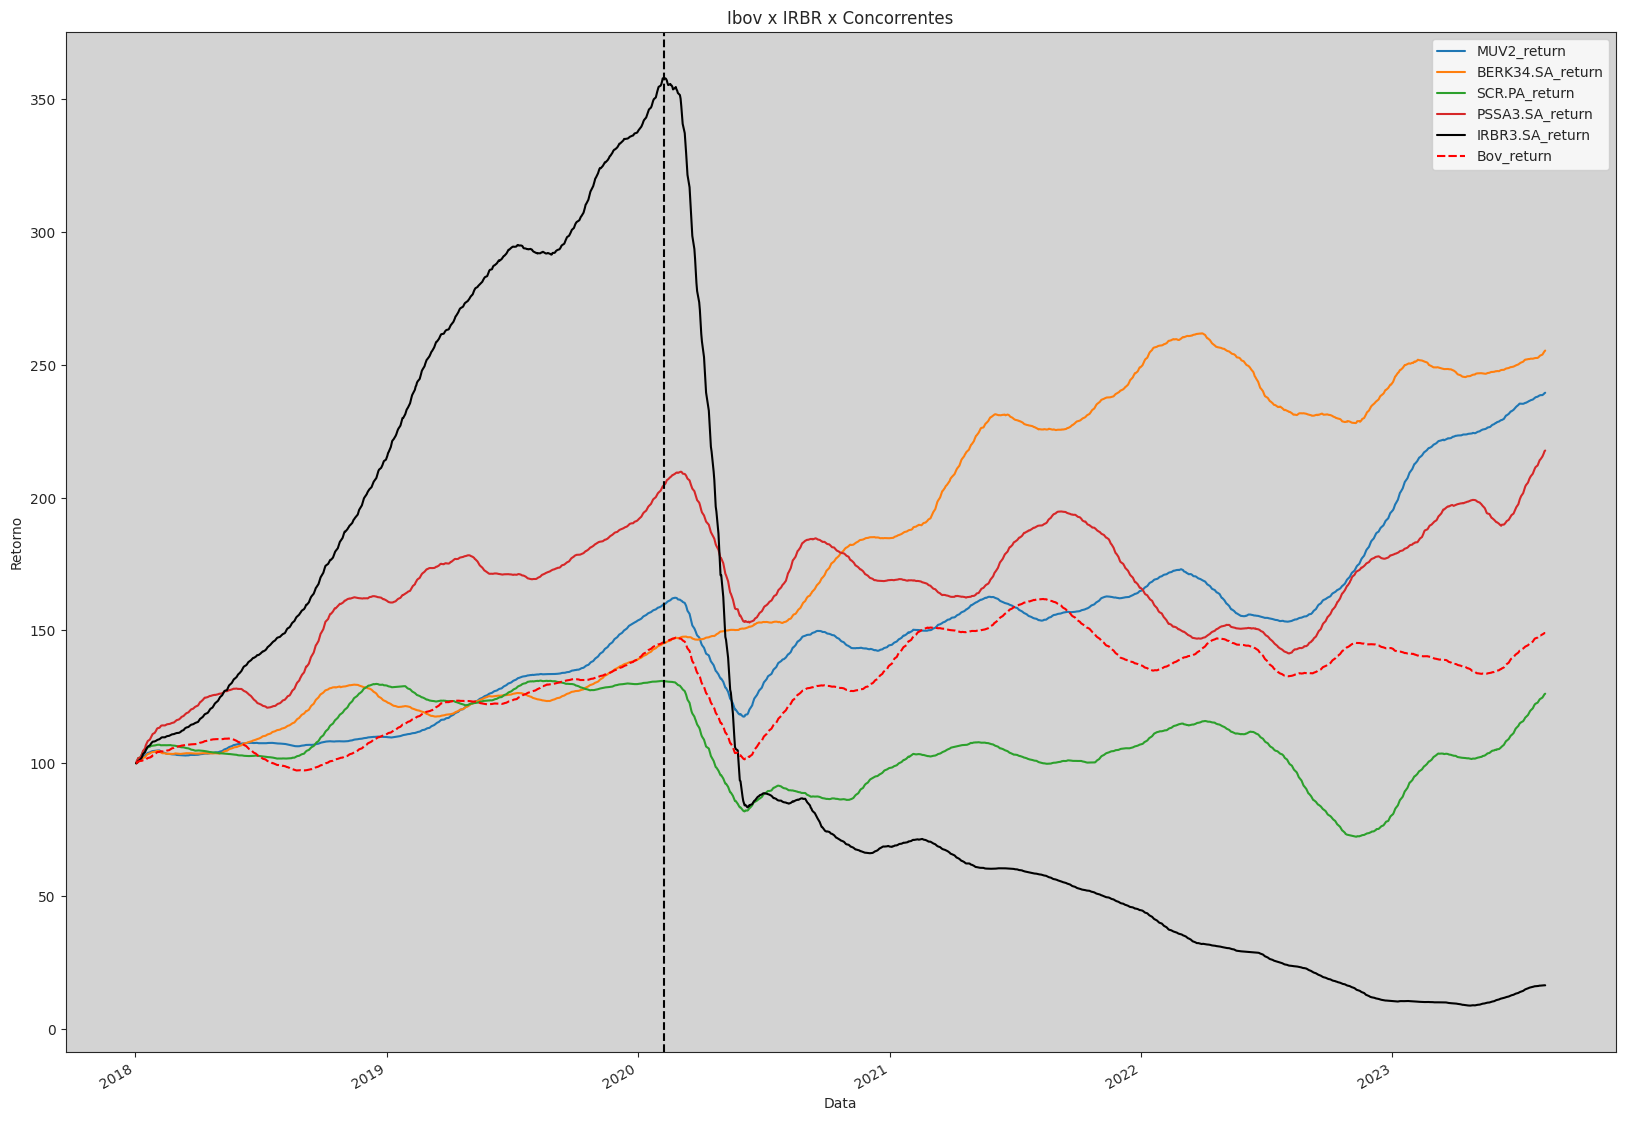

In [ ]:
ax=(df_con_irbr_pct_return[["MUV2_return","BERK34.SA_return","SCR.PA_return","PSSA3.SA_return"]].plot(figsize=(20, 15)))
sb.lineplot(data=df_con_irbr_pct_return_irbr, palette=["black","red"])
ax.set_ylabel("Retorno")
ax.set_facecolor("lightgrey")
ax.set_xlabel("Data")
ax.set_title("Ibov x IRBR x Concorrentes")
ax.axvline(x=target_date, color="black", linestyle="--")

ax.figure.savefig('df_con_irbr_pct_return.jpeg', dpi=600)

# Americana

Início em Janeiro/2023 sem data fim

A empresa Americanas confirmou oficialmente a existência de uma fraude bilionária em seus resultados financeiros, revelada em um relatório preliminar. A fraude envolveu práticas contábeis questionáveis realizadas pela antiga diretoria da empresa, incluindo nomes como Miguel Gutierrez, Anna Saicali, Timotheo Barros e Márcio Meirelles.

O relatório apontou que a diretoria anterior da Americanas fraudava demonstrações financeiras para aumentar os lucros, resultando em pagamentos excessivos de bônus para os executivos. Nos últimos anos, a diretoria recebeu mais de R$ 500 milhões em bônus, um valor muito acima do padrão do setor.

A fraude envolveu a manipulação de verbas publicitárias em acordos com fornecedores, onde a empresa contabilizava essas verbas antes de recebê-las, e empréstimos inadequadamente contabilizados, totalizando um valor de R$ 21,7 bilhões e R$ 20,6 bilhões, respectivamente.

O relatório não esclareceu completamente qual era o nível de conhecimento dos acionistas sobre essas práticas. A expectativa é que os acionistas Jorge Paulo Lemann, Marcel Telles e Carlos Alberto Sicupira se afastem temporariamente da gestão direta da empresa até que a situação seja resolvida judicialmente.

Essas revelações impactaram não apenas a Americanas, mas também têm implicações significativas para o mercado financeiro e para o setor de varejo. A empresa enfrenta consequências legais e desafios para restaurar a confiança dos investidores e do público.

In [ ]:
#unindo americans com concorrente
df_con_ame=pd.merge(df_con_ame, df_AMER3, how="left", left_index=True, right_index=True)

In [ ]:
#unindo concorrentes com Ibovespa
df_con_ame=pd.merge(df_con_ame, df_bovespa, how="left", left_index=True, right_index=True)


In [ ]:
#transformando index em datetime
df_con_ame.index=pd.to_datetime(df_con_ame.index)

In [ ]:
#completando NA com zero
df_con_ame=df_con_ame.fillna(0)

In [ ]:
#2 anos antes da data crime
df_con_ame=df_con_ame.loc["2021-01-01":]

In [ ]:
df_con_ame.head(2)

,MGLU3.SA,VIIA3.SA,CRFB3.SA,AMER3.SA,Bovespa
Date,,,,,
2021-01-04,25.181740,16.170000,17.508263,73.699677,118558.0
2021-01-05,24.742058,16.219999,17.389406,72.052757,119223.0


In [ ]:
df_con_ame_time_perc=df_con_ame.loc["2023-01-04":].pct_change()*100


df_con_ame_time_perc.sort_index(ascending=True)

df_con_ame_time_perc.head()

df_con_irbr_time_perc.to_csv("/content/df_con_ame_time_perc.csv")

In [ ]:

df_con_ame["MGLU3.SA_return"]=df_con_ame["MGLU3.SA"].rolling('90D').mean()

df_con_ame["VIIA3.SA_return"]=df_con_ame["VIIA3.SA"].rolling("90D").mean()

df_con_ame["CRFB3.SA_return"]=df_con_ame["CRFB3.SA"].rolling("90D").mean()

df_con_ame["AMER3.SA_return"]=df_con_ame["AMER3.SA"].rolling("90D").mean()

df_con_ame["Bov_return"]=df_con_ame["Bovespa"].rolling("90D").mean()



In [ ]:
df_con_ame_pct=df_con_ame.pct_change().fillna(0)

In [ ]:
df_con_ame_pct_return=round((((1 + df_con_ame_pct).cumprod()-1)*100),2)+100

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


In [ ]:
df_con_ame_pct_return.to_csv("/content/df_con_ame_apresentacao.csv")

In [ ]:
target_date_str = "2023-01-11"
target_date = dt.strptime(target_date_str, "%Y-%m-%d")  # Use %Y instead of %YYY

In [ ]:
df_con_ame_pct_return_ame=df_con_ame_pct_return[["AMER3.SA_return","Bov_return"]]

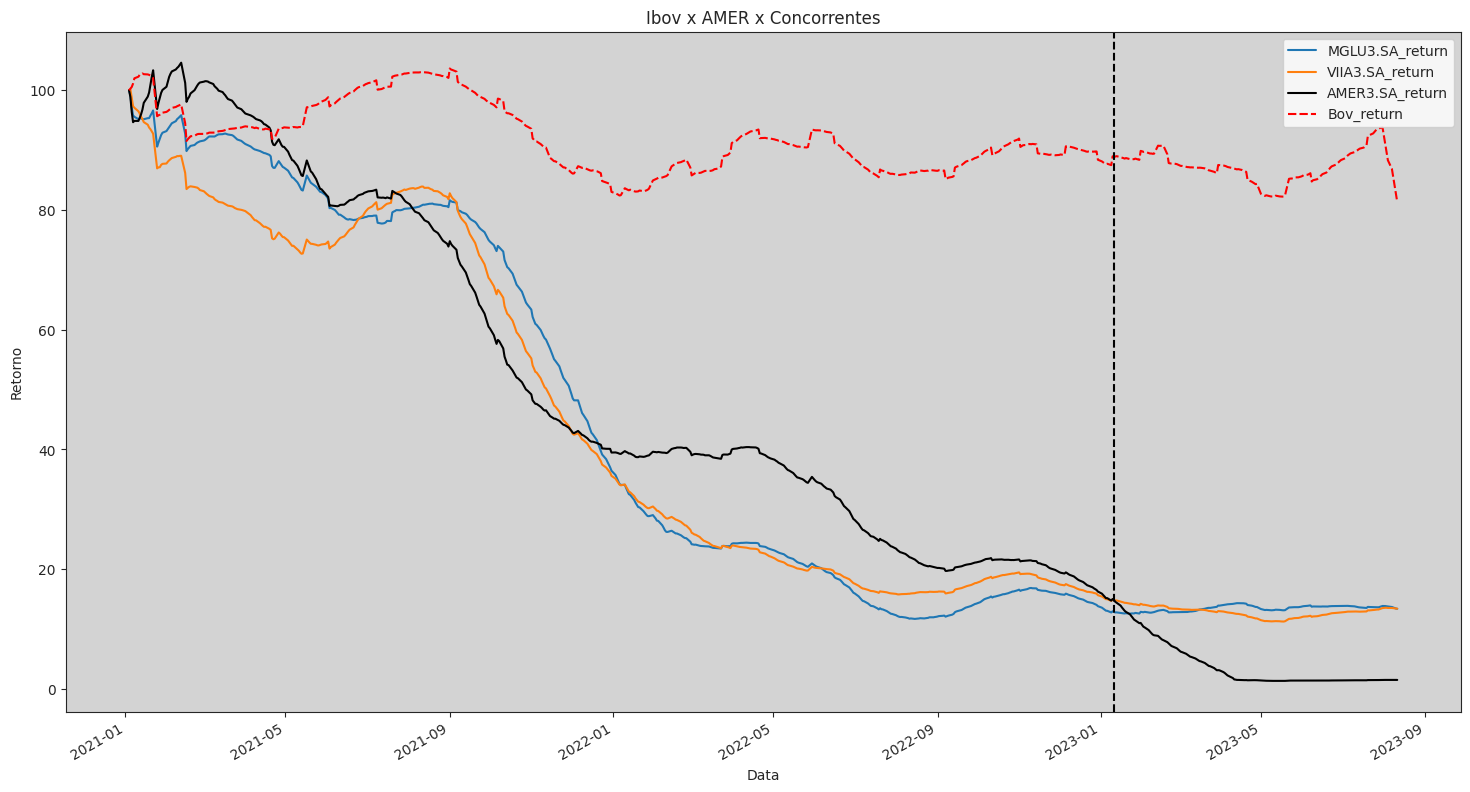

In [ ]:
ax=(df_con_ame_pct_return[["MGLU3.SA_return",	"VIIA3.SA_return"]].plot(figsize=(18, 10)))
sb.lineplot(data=df_con_ame_pct_return_ame, palette=["black", "red"])
ax.set_ylabel("Retorno")
ax.set_facecolor("lightgrey")
ax.set_xlabel("Data")
ax.set_title("Ibov x AMER x Concorrentes")
ax.axvline(x=target_date, color="black", linestyle="--")
ax.figure.savefig('df_con_amer_pct_return.jpeg', dpi=600)

 # JBS

Ínício Maio/2017 com fim em Setembro/2021

O escândalo envolvendo a JBS veio à tona em maio de 2017. A JBS é uma das maiores empresas de processamento de carnes do mundo, com sede no Brasil. As revelações surgiram de uma investigação policial conhecida como "Operação Carne Fraca", que expôs irregularidades nas práticas de produção e fiscalização sanitária de várias empresas do setor de carne, incluindo a JBS.

As investigações apontaram que a JBS estava envolvida em esquemas de corrupção para obter licenças sanitárias e subornar funcionários públicos encarregados de inspeções de alimentos. Esses eventos abalaram a confiança dos consumidores tanto no Brasil quanto internacionalmente.

No entanto, é importante destacar que a JBS já estava envolvida em controvérsias anteriores, incluindo questões relacionadas a empréstimos subsidiados pelo governo, alegações de práticas trabalhistas inadequadas e outros problemas antes do escândalo de 2017.

In [ ]:
#unindo as tabelas jbs e concorrente
df_con_jbs=pd.merge(df_jbs,df_con_jbs, how="left", left_index=True, right_index=True)

In [ ]:
#unindo as tabelas com bovespa
df_con_jbs=pd.merge(df_con_jbs, df_bovespa, how="left", left_index=True, right_index=True)

In [ ]:
df_con_jbs.fillna(0)

,JBSS3.SA,AALR3.SA,BEEF3.SA,MRFG3.SA,BRFS3.SA,Bovespa
Date,,,,,,
2008-01-02,4.003692,0.000000,7.897236,9.769298,18.938053,62815.0
2008-01-03,3.936401,0.000000,8.179280,9.775706,19.027386,62892.0
2008-01-04,3.902759,0.000000,8.090214,9.775706,18.357407,61037.0
2008-01-07,3.889301,0.000000,8.090214,9.711605,18.938053,60772.0
2008-01-08,3.795096,0.000000,8.142170,9.743655,18.982723,62081.0
...,...,...,...,...,...,...
2023-08-07,19.450001,24.270000,10.620000,8.090000,10.080000,0.0
2023-08-08,19.469999,24.110001,10.610000,7.940000,9.850000,0.0
2023-08-09,19.260000,23.150000,10.750000,7.800000,9.660000,0.0


In [ ]:
#transformando index para datetime
df_con_jbs.index=pd.to_datetime(df_con_jbs.index)

In [ ]:
df_con_jbs_time_perc=df_con_jbs.loc["2017-05-10":"2019-05-10"].pct_change()*100


df_con_jbs_time_perc.sort_index(ascending=True)

df_con_jbs_time_perc.head()

df_con_jbs_time_perc.to_csv("/content/df_con_jbs_time_perc.csv")

In [ ]:
df_con_jbs=df_con_jbs.loc["2015-01-01":"2023-07-30"]

In [ ]:
window_size=90

In [ ]:
df_con_jbs["AALR3.SA_result"]=df_con_jbs["AALR3.SA"].rolling(window=window_size).mean()

df_con_jbs["BEEF3.SA_result"]=df_con_jbs["BEEF3.SA"].rolling(window=window_size).mean()

df_con_jbs["MRFG3.SA_result"]=df_con_jbs["MRFG3.SA"].rolling(window=window_size).mean()

df_con_jbs["BRFS3.SA_result"]=df_con_jbs["BRFS3.SA"].rolling(window=window_size).mean()

df_con_jbs["JBSS3.SA_result"]=df_con_jbs["JBSS3.SA"].rolling(window=window_size).mean()

df_con_jbs["BOV_result"]=df_con_jbs["Bovespa"].rolling(window=window_size).mean()




In [ ]:
df_con_jbs

,JBSS3.SA,AALR3.SA,BEEF3.SA,MRFG3.SA,BRFS3.SA,Bovespa,AALR3.SA_result,BEEF3.SA_result,MRFG3.SA_result,BRFS3.SA_result,JBSS3.SA_result,BOV_result
Date,,,,,,,,,,,,
2015-01-02,7.596037,NaN,7.316798,3.744115,60.129284,48512.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,7.632037,NaN,6.969482,3.459668,58.988201,47517.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,7.452036,NaN,6.869144,3.406748,59.520061,48001.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,7.660837,NaN,7.324516,3.525819,62.179371,49463.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,7.725637,NaN,7.293643,3.591969,61.067295,49943.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-24,17.889999,24.150000,9.600000,6.940000,8.580000,121342.0,23.076000,9.984767,6.846222,7.654667,16.900222,110192.233333
2023-07-25,17.930000,24.170000,9.340000,6.830000,8.390000,122008.0,23.096889,9.970147,6.845778,7.673556,16.896945,110407.044444
2023-07-26,18.250000,24.129999,9.500000,6.910000,8.570000,122560.0,23.114000,9.954742,6.843667,7.694444,16.889544,110619.544444


In [ ]:
df_con_jbs_pct=df_con_jbs.pct_change().fillna(0)

In [ ]:
df_con_jbs_return=(((1+df_con_jbs_pct).cumprod()-1)*100)+100

In [ ]:
df_con_jbs_return.to_csv("/content/df_con_jbs_apresentacao.csv")

In [ ]:
df_con_jbs_return_pct=df_con_jbs_return[["JBSS3.SA_result","BOV_result"]]

In [ ]:
df_con_jbs_return.head(1)

,JBSS3.SA,AALR3.SA,BEEF3.SA,MRFG3.SA,BRFS3.SA,Bovespa,AALR3.SA_result,BEEF3.SA_result,MRFG3.SA_result,BRFS3.SA_result,JBSS3.SA_result,BOV_result
Date,,,,,,,,,,,,
2015-01-02,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [ ]:
target_date_str = "2017-05-17"
target_date = dt.strptime(target_date_str, "%Y-%m-%d")  # Use %Y instead of %YYY

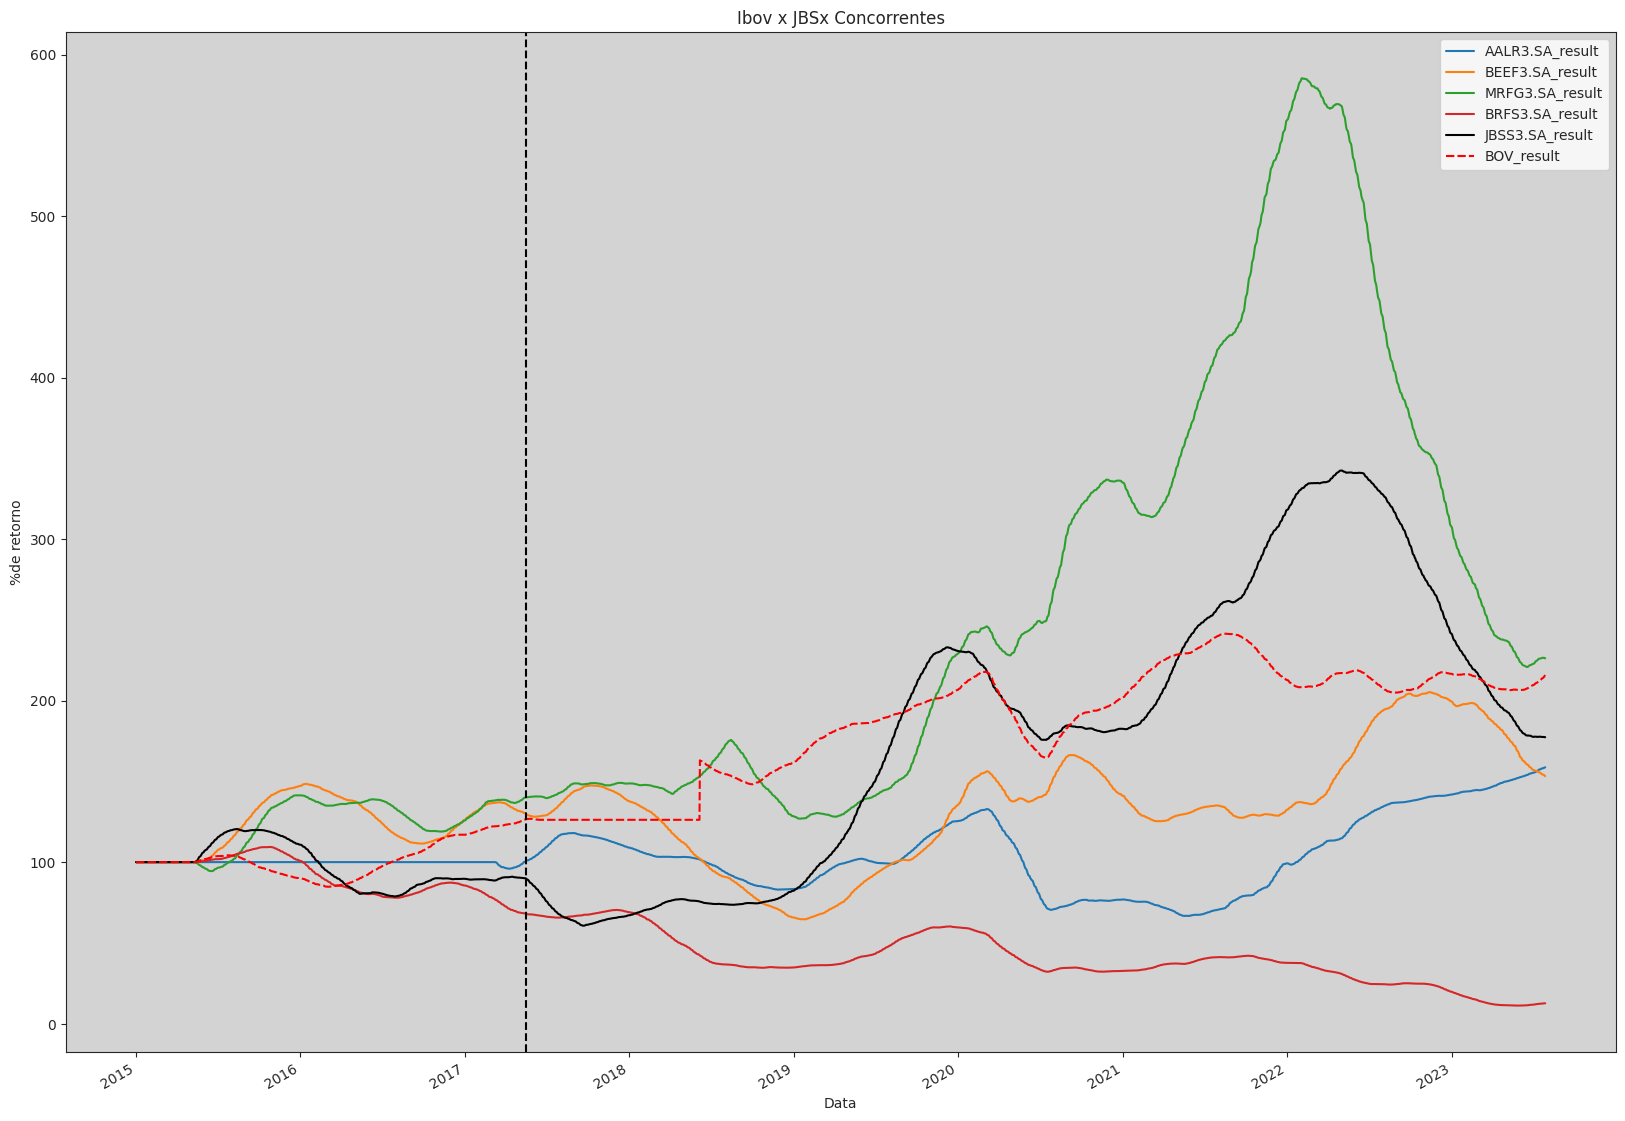

In [ ]:
ax=(df_con_jbs_return[["AALR3.SA_result","BEEF3.SA_result","MRFG3.SA_result","BRFS3.SA_result"]].plot(figsize=(20, 15)))
sb.lineplot(data=df_con_jbs_return_pct, palette=["black","red"])
ax.set_ylabel("%de retorno")
ax.set_xlabel("Data")
ax.set_title("Ibov x JBSx Concorrentes")
ax.set_facecolor("lightgrey")
ax.axvline(x=target_date, color="black", linestyle="--")
ax.figure.savefig('df_con_JBS_pct_return.jpeg', dpi=600)